# 1 US Stock Market Data  

Using [Yahoo! Finance](https://finance.yahoo.com/) as your data source, download daily prices for S&P 500 and eleven stocks which are part of this index, each representing one of the [GICS](https://www.msci.com/our-solutions/indexes/gics) sectors. You can choose any set of stocks that satisfy these criteria.

Repeat the EDA presented in the lectures. You are most welcome to amend the code as you find fit. It is important that you discuss your results and provide intuition and interpretation for your findings. This analysis should be augmented with the following information for the index and stock returns calculated from closing prices:

In [57]:
# Import / install relevant Python packages
import numpy as np

import pandas as pd     
import pandas_datareader as pdr       # pip install pandas-datareader
from pandas_datareader import wb

import scipy
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

import pylab as py

from sklearn.impute import SimpleImputer

import yfinance as yf                 # pip install yfinance
import wbdata                         # pip install wbdata

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Define tickers
''' ^GSPC - S&P500
11 random companies from different sectors included in S&P500:
energy - XOM (ExxonMobil) 
materials - BALL (Ball Corporation)
industrials - GE (General Electric)
consumer discretionary - TSLA (Tesla Inc.)
consumer staples - KO (Coca Cola Company)
health care - ABT (Abott)
financials - GS (Goldman Sachs)
information technology - CSCO (Cisco)
communication services - NFLX (Netflix)
utilities - NRG (NRG Energy)
real estate - IRM (Iron Mountain)'''

tickers = ['^GSPC', 'XOM','BALL','GE','TSLA','KO','ABT','GS','CSCO','NFLX','NRG','IRM']
names = ['S&P500', 'ExxonMobil', 'Ball Corporation', 'General Electric', 'Tesla Inc.', 
        'Coca Cola Company', 'Abott', 'Goldman Sachs', 'Cisco', 'Netflix', 'NRG Energy', 'Iron Mountain']

In [3]:
# Define starting and ending date (Format: yyyy,m/mm,d/dd)
#start_date = dt.datetime(2021,1,1)
#end_date   = dt.datetime.today()

##### Data to prices and returns conversion + descriptive info & statistics

In [16]:
# Download data
df_stock_prices = yf.download(tickers,group_by='ticker')
display(df_stock_prices)  

[*********************100%***********************]  12 of 12 completed


CSCO                                                          \
                 Open       High        Low      Close  Adj Close      Volume   
Date                                                                            
1950-01-03        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-04        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-05        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-06        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-09        NaN        NaN        NaN        NaN        NaN         NaN   
...               ...        ...        ...        ...        ...         ...   
2022-09-26  40.660000  41.189999  40.369999  40.580002  40.580002  22694800.0   
2022-09-27  41.139999  41.459999  40.230000  40.520000  40.520000  15027900.0   
2022-09-28  40.849998  41.570000  40.590000  41.340000  41.340000  23217700.0   
2022-09-29  41.049999  41.099998  40.150002  40.570000  40.570000  19496400.0   
2022-09-30  40.660000  41.040001  39.959999  40.000000  40.000000  27987900.0   

                   ABT                                    ...        ^GSPC  \
                  Open        High        Low      Close  ...          Low   
Date                                                      ...                
1950-01-03         NaN         NaN        NaN        NaN  ...    16.660000   
1950-01-04         NaN         NaN        NaN        NaN  ...    16.850000   
1950-01-05         NaN         NaN        NaN        NaN  ...    16.930000   
1950-01-06         NaN         NaN        NaN        NaN  ...    16.980000   
1950-01-09         NaN         NaN        NaN        NaN  ...    17.080000   
...                ...         ...        ...        ...  ...          ...   
2022-09-26  100.180000  100.650002  99.260002  99.839996  ...  3644.760010   
2022-09-27  100.250000  100.730003  97.910004  98.330002  ...  3623.290039   
2022-09-28   98.070000   99.269997  97.570000  98.720001  ...  3640.610107   
2022-09-29   98.849998   99.180000  97.550003  98.290001  ...  3610.399902   
2022-09-30   98.709999   99.500000  96.669998  96.760002  ...  3584.129883   

                                                         GE             \
                  Close    Adj Close      Volume       Open       High   
Date                                                                     
1950-01-03    16.660000    16.660000     1260000        NaN        NaN   
1950-01-04    16.850000    16.850000     1890000        NaN        NaN   
1950-01-05    16.930000    16.930000     2550000        NaN        NaN   
1950-01-06    16.980000    16.980000     2010000        NaN        NaN   
1950-01-09    17.080000    17.080000     2520000        NaN        NaN   
...                 ...          ...         ...        ...        ...   
2022-09-26  3655.040039  3655.040039  4886140000  64.529999  66.160004   
2022-09-27  3647.290039  3647.290039  4577740000  64.849998  65.309998   
2022-09-28  3719.040039  3719.040039  4684850000  64.989998  65.059998   
2022-09-29  3640.469971  3640.469971  4681810000  63.770000  64.110001   
2022-09-30  3585.620117  3585.620117  5645360000  62.639999  63.290001   

                                                         
                  Low      Close  Adj Close      Volume  
Date                                                     
1950-01-03        NaN        NaN        NaN         NaN  
1950-01-04        NaN        NaN        NaN         NaN  
1950-01-05        NaN        NaN        NaN         NaN  
1950-01-06        NaN        NaN        NaN         NaN  
1950-01-09        NaN        NaN        NaN         NaN  
...               ...        ...        ...         ...  
2022-09-26  64.209999  64.349998  64.349998  10454600.0  
2022-09-27  63.509998  64.470001  64.470001   7848000.0  
2022-09-28  64.190002  64.459999  64.459999   6657700.0  
2022-09-29  61.919998  62.730000  62.730000   8799700.0 

In [17]:
# Get high-level info: Aggregated view
df_stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 72 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (CSCO, Open)        8219 non-null   float64
 1   (CSCO, High)        8219 non-null   float64
 2   (CSCO, Low)         8219 non-null   float64
 3   (CSCO, Close)       8219 non-null   float64
 4   (CSCO, Adj Close)   8219 non-null   float64
 5   (CSCO, Volume)      8219 non-null   float64
 6   (ABT, Open)         10728 non-null  float64
 7   (ABT, High)         10728 non-null  float64
 8   (ABT, Low)          10728 non-null  float64
 9   (ABT, Close)        10728 non-null  float64
 10  (ABT, Adj Close)    10728 non-null  float64
 11  (ABT, Volume)       10728 non-null  float64
 12  (XOM, Open)         15293 non-null  float64
 13  (XOM, High)         15293 non-null  float64
 14  (XOM, Low)          15293 non-null  float64
 15  (XOM, Close)        15293 non-null  

In [18]:
# Get high-level info: Segmented view
for iticker in tickers:
    print(iticker)
    df_stock_prices[iticker].info()
    print('-'*100)

^GSPC
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       18306 non-null  float64
 1   High       18306 non-null  float64
 2   Low        18306 non-null  float64
 3   Close      18306 non-null  float64
 4   Adj Close  18306 non-null  float64
 5   Volume     18306 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1001.1 KB
----------------------------------------------------------------------------------------------------
XOM
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       15293 non-null  float64
 1   High       15293 non-null  float64
 2   Low        15293 non-null  float64
 3   Close      15293 non-null  float64
 4   Adj Close  15293 non-

In [19]:
# Get basic descriptive statistics
df_stock_prices.describe()

CSCO                                                      \
              Open         High          Low        Close    Adj Close   
count  8219.000000  8219.000000  8219.000000  8219.000000  8219.000000   
mean     22.596819    22.889479    22.294647    22.593604    18.126471   
std      16.320778    16.530319    16.096210    16.317033    14.626356   
min       0.000000     0.072917     0.068576     0.071181     0.051017   
25%      10.927083    11.071250    10.703125    10.913333     7.821871   
50%      20.870001    21.100000    20.650000    20.860001    15.117085   
75%      29.760000    30.000000    29.460000    29.750000    23.176802   
max      81.437500    82.000000    79.062500    80.062500    62.589500   

                              ABT                                            \
             Volume          Open          High           Low         Close   
count  8.219000e+03  10728.000000  10728.000000  10728.000000  10728.000000   
mean   5.407367e+07     25.204849     25.511124     25.015436     25.273062   
std    4.124843e+07     28.716231     28.930664     28.388211     28.664577   
min    8.064000e+05      0.000000      0.490985      0.478711      0.487478   
25%    2.837735e+07      4.713459      4.769572      4.667868      4.713459   
50%    4.636020e+07     19.453491     19.695526     19.270754     19.480054   
75%    6.610130e+07     28.213439     28.479728     27.955547     28.260220   
max    9.406368e+08    141.580002    142.600006    140.720001    141.460007   

       ...         ^GSPC                                            \
       ...           Low         Close     Adj Close        Volume   
count  ...  18306.000000  18306.000000  18306.000000  1.830600e+04   
mean   ...    720.995344    725.759702    725.759702  1.082945e+09   
std    ...    947.226770    953.174571    953.174571  1.680212e+09   
min    ...     16.660000     16.660000     16.660000  6.800000e+05   
25%    ...     87.035000     87.807503     87.807503  9.920000e+06   
50%    ...    234.449997    235.940002    235.940002  1.277400e+08   
75%    ...   1171.252533   1179.657532   1179.657532  1.566150e+09   
max    ...   4780.040039   4796.560059   4796.560059  1.145623e+10   

                 GE                                                          \
               Open          High           Low         Close     Adj Close   
count  15293.000000  15293.000000  15293.000000  15293.000000  15293.000000   
mean      97.104469     98.134389     96.011624     97.088644     63.946593   
std      104.776549    105.922743    103.576780    104.781898     71.270150   
min        4.447115      4.517228      4.346955      4.447115      0.759388   
25%        8.954327      9.014423      8.864183      8.954327      2.238798   
50%       49.038464     49.439102     48.557693     48.958332     22.795866   
75%      180.461533    182.307693    178.685898    180.153839    121.015343   
max      458.173065    465.384613    457.211548    461.538452    255.183258   

                     
             Volume  
count  1.529300e+04  
mean   3.179379e+06  
std    4.297504e+06  
min    0.000000e+00  
25%    6.552000e+05  
50%    1.853124e+06  
75%    3.857932e+06  
max    9.787757e+07  

[8 rows x 72 columns]

In [20]:
# Creating a data frame consisting of stock returns
fields_prices    = ['Open', 'High', 'Low', 'Close', 'Adj Close']
fields_all       = df_stock_prices.columns.get_level_values(1).drop_duplicates().tolist()
fields_drop      = list(set(fields_all) - set(fields_prices))
print(fields_all)
print(fields_drop)

df_stock_returns = df_stock_prices.copy()
df_stock_returns = df_stock_returns.drop(fields_drop, level=1, axis=1)
df_stock_returns = df_stock_returns.pct_change(fill_method=None)
display(df_stock_returns)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Volume']


CSCO                                               ABT  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.014303 -0.001455  0.006231 -0.001967 -0.001967 -0.002092   
2022-09-27  0.011805  0.006555 -0.003468 -0.001479 -0.001479  0.000699   
2022-09-28 -0.007049  0.002653  0.008949  0.020237  0.020237 -0.021746   
2022-09-29  0.004896 -0.011306 -0.010840 -0.018626 -0.018626  0.007953   
2022-09-30 -0.009501 -0.001460 -0.004732 -0.014050 -0.014050 -0.001416   

                                                    ...     ^GSPC            \
                High       Low     Close Adj Close  ...      Open      High   
Date                                                ...                       
1950-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN  ...  0.011405  0.011405   
1950-01-05       NaN       NaN       NaN       NaN  ...  0.004748  0.004748   
1950-01-06       NaN       NaN       NaN       NaN  ...  0.002953  0.002953   
1950-01-09       NaN       NaN       NaN       NaN  ...  0.005889  0.005889   
...              ...       ...       ...       ...  ...       ...       ...   
2022-09-26 -0.002379  0.004554 -0.008343 -0.008343  ... -0.011918 -0.003077   
2022-09-27  0.000795 -0.013601 -0.015124 -0.015124  ...  0.001010  0.000501   
2022-09-28 -0.014494 -0.003473  0.003966  0.003966  ... -0.009359  0.005167   
2022-09-29 -0.000907 -0.000205 -0.004356 -0.004356  ...  0.009603 -0.013308   
2022-09-30  0.003226 -0.009021 -0.015566 -0.015566  ... -0.014519 -0.004223   

                                                GE                      \
                 Low     Close Adj Close      Open      High       Low   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04  0.011405  0.011405  0.011405       NaN       NaN       NaN   
1950-01-05  0.004748  0.004748  0.004748       NaN       NaN       NaN   
1950-01-06  0.002953  0.002953  0.002953       NaN       NaN       NaN   
1950-01-09  0.005889  0.005889  0.005889       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.000743 -0.010341 -0.010341 -0.000310  0.016595  0.010386   
2022-09-27 -0.005891 -0.002120 -0.002120  0.004959 -0.012848 -0.010902   
2022-09-28  0.004780  0.019672  0.019672  0.002159 -0.003828  0.010707   
2022-09-29 -0.008298 -0.021126 -0.021126 -0.018772 -0.014602 -0.035364   
2022-09-30 -0.007276 -0.015067 -0.015067 -0.017720 -0.012791 -0.000646   

                                
               Close Adj Close  
Date                            
1950-01-03       NaN       NaN  
1950-01-04       NaN       NaN  
1950-01-05       NaN       NaN  
1950-01-06       NaN       NaN  
1950-01-09       NaN       NaN  
...              ...       ...  
2022-09-26 -0.003098 -0.001861  
2022-09-27  0.001865  0.001865  
2022-09-28 -0.000155 -0.000155  
2022-09-29 -0.026838 -0.026838  
2022-09-30 -0.013072 -0.013072  

[18306 rows x 60 columns]

In [21]:
# Get basic info
df_stock_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18306 entries, 1950-01-03 to 2022-09-30
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (CSCO, Open)        8194 non-null   float64
 1   (CSCO, High)        8218 non-null   float64
 2   (CSCO, Low)         8218 non-null   float64
 3   (CSCO, Close)       8218 non-null   float64
 4   (CSCO, Adj Close)   8218 non-null   float64
 5   (ABT, Open)         9956 non-null   float64
 6   (ABT, High)         10727 non-null  float64
 7   (ABT, Low)          10727 non-null  float64
 8   (ABT, Close)        10727 non-null  float64
 9   (ABT, Adj Close)    10727 non-null  float64
 10  (XOM, Open)         13306 non-null  float64
 11  (XOM, High)         15292 non-null  float64
 12  (XOM, Low)          15292 non-null  float64
 13  (XOM, Close)        15292 non-null  float64
 14  (XOM, Adj Close)    15292 non-null  float64
 15  (IRM, Open)         6712 non-null   

In [22]:
# Get basic descriptive statistics
df_stock_returns.describe()

CSCO                                                      \
              Open         High          Low        Close    Adj Close   
count  8194.000000  8218.000000  8218.000000  8218.000000  8218.000000   
mean           inf     0.000994     0.001062     0.001083     0.001124   
std            NaN     0.021647     0.024338     0.025432     0.025427   
min      -0.193878    -0.190954    -0.207208    -0.198276    -0.198276   
25%      -0.010568    -0.008436    -0.009470    -0.010650    -0.010569   
50%       0.000912     0.000000     0.001195     0.000590     0.000634   
75%       0.012805     0.010223     0.011093     0.012579     0.012614   
max            inf     0.207407     0.280822     0.243884     0.243883   

               ABT                                                          \
              Open          High           Low         Close     Adj Close   
count  9956.000000  10727.000000  10727.000000  10727.000000  10727.000000   
mean           inf      0.000596      0.000616      0.000621      0.000704   
std            NaN      0.014471      0.015748      0.016157      0.016141   
min      -0.149020     -0.124031     -0.192118     -0.161375     -0.161375   
25%      -0.008377     -0.006705     -0.006858     -0.008180     -0.008074   
50%       0.000000      0.000000      0.000405      0.000000      0.000000   
75%       0.009159      0.007818      0.008313      0.009205      0.009259   
max            inf      0.165186      0.241611      0.124664      0.124664   

       ...         ^GSPC                                            \
       ...          Open          High           Low         Close   
count  ...  1.323900e+04  18305.000000  18305.000000  18305.000000   
mean   ...           inf      0.000330      0.000338      0.000343   
std    ...           NaN      0.008345      0.009385      0.009923   
min    ... -1.000000e+00     -0.131164     -0.201371     -0.204669   
25%    ... -4.046933e-03     -0.003628     -0.003963     -0.004066   
50%    ...  6.901520e-04      0.000427      0.000634      0.000487   
75%    ...  5.274254e-03      0.004464      0.004860      0.005031   
max    ...           inf      0.080379      0.106719      0.115800   

                               GE                                            \
          Adj Close          Open          High           Low         Close   
count  18305.000000  15292.000000  15292.000000  15292.000000  15292.000000   
mean       0.000343      0.000310      0.000272      0.000295      0.000302   
std        0.009923      0.017710      0.015482      0.016786      0.017284   
min       -0.204669     -0.231121     -0.112775     -0.221105     -0.174877   
25%       -0.004066     -0.008185     -0.007143     -0.006944     -0.008180   
50%        0.000487      0.000000      0.000000      0.000000      0.000000   
75%        0.005031      0.008435      0.007342      0.007735      0.008496   
max        0.115800      0.226622      0.160560      0.218750      0.197031   

                     
          Adj Close  
count  15292.000000  
mean       0.000418  
std        0.017278  
min       -0.174877  
25%       -0.008032  
50%        0.000000  
75%        0.008646  
max        0.197030  

[8 rows x 60 columns]

#### Plotting prices, volume, returns & their Simple Moving Averages (SMA) for 60 and 250 days

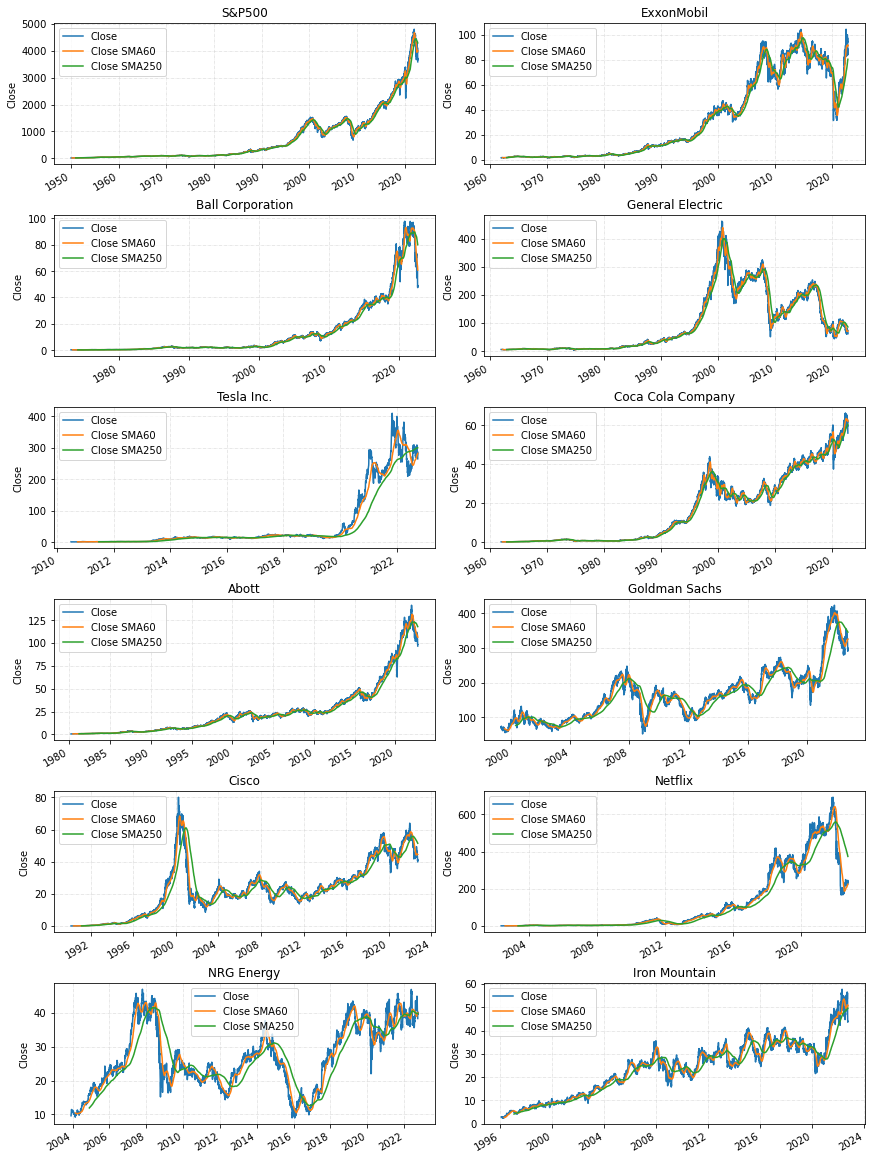

In [23]:
# Plotting closing prices (and simple moving averages)
plt.figure(figsize=(12, 16), constrained_layout = True)
for iticker in range(len(tickers)):
    # Calculate simple moving average (60 and 250 days)
    df_stock_prices[tickers[iticker],'Close SMA60'] = (
        df_stock_prices[tickers[iticker]]['Close'].rolling(60).mean()) 
    df_stock_prices[tickers[iticker],'Close SMA250'] = (
        df_stock_prices[tickers[iticker]]['Close'].rolling(250).mean()) 
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_prices[tickers[iticker]]['Close'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Close SMA60'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Close SMA250'].plot(linewidth=1.5)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.legend(['Close','Close SMA60','Close SMA250'])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

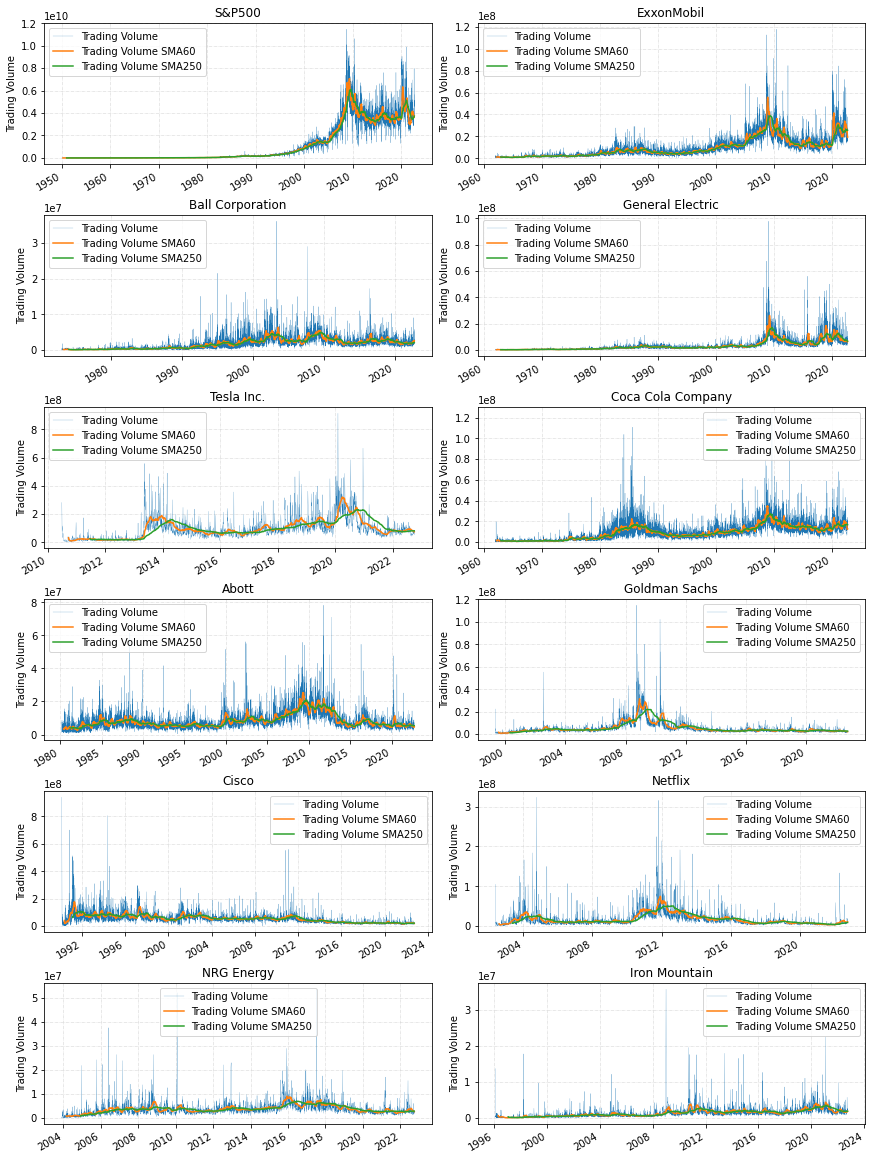

In [24]:
# Plotting trading volume (and simple moving averages)
plt.figure(figsize=(12, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Calculate simple moving average (60 and 250 days)
    df_stock_prices[tickers[iticker],'Volume SMA60'] = (
        df_stock_prices[tickers[iticker]]['Volume'].rolling(60).mean()) 
    df_stock_prices[tickers[iticker],'Volume SMA250'] = (
        df_stock_prices[tickers[iticker]]['Volume'].rolling(250).mean()) 
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_prices[tickers[iticker]]['Volume'].plot(linewidth=0.2)
    df_stock_prices[tickers[iticker]]['Volume SMA60'].plot(linewidth=1.5)
    df_stock_prices[tickers[iticker]]['Volume SMA250'].plot(linewidth=1.5)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Trading Volume')
    plt.title(names[iticker])
    plt.legend(['Trading Volume',
                'Trading Volume SMA60',
                'Trading Volume SMA250'])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

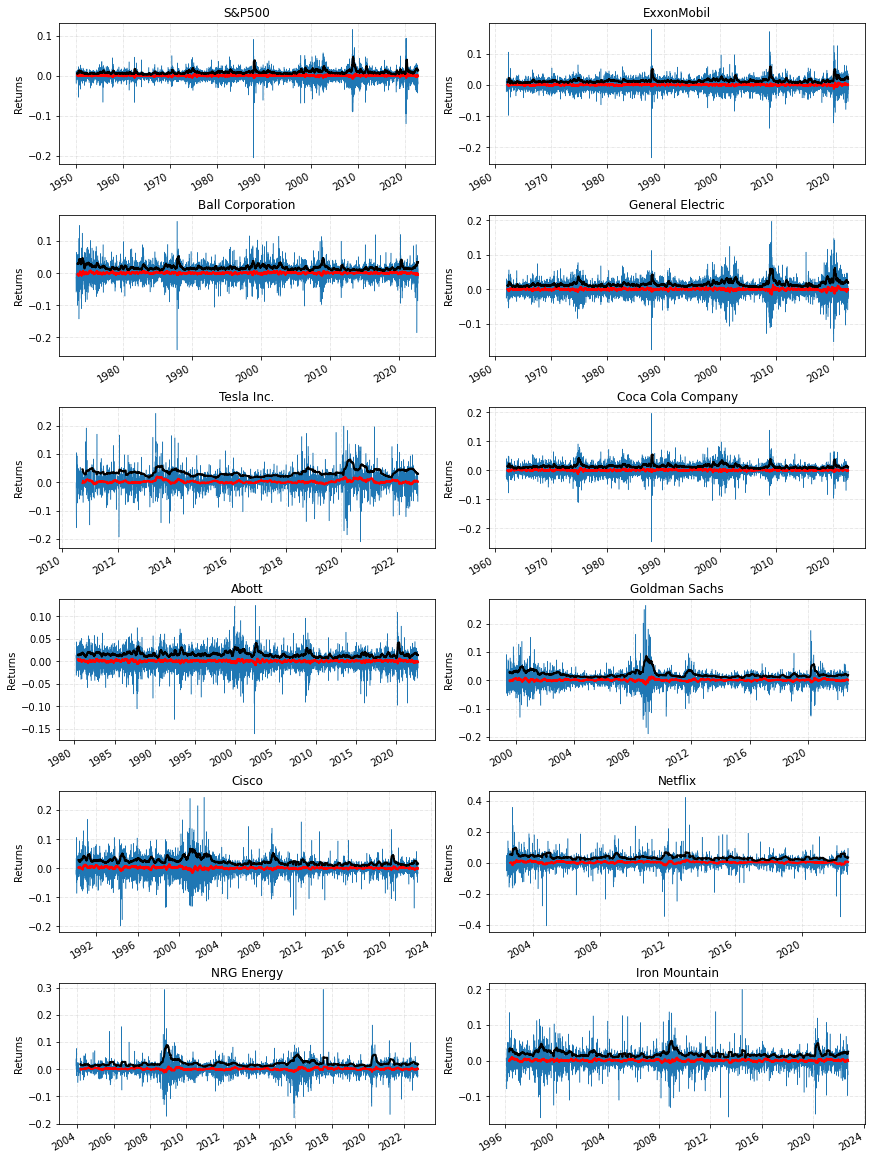

In [25]:
# Plotting returns (calculated from close price)
plt.figure(figsize=(12, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Calculate rolling mean and standard deviation
    irollmean =  df_stock_returns[tickers[iticker]]['Close'].rolling(60).mean()
    irollvola =  df_stock_returns[tickers[iticker]]['Close'].rolling(60).std()
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    df_stock_returns[tickers[iticker]]['Close'].plot(linewidth=0.5)
    irollmean.plot(linewidth=2, color='red')
    irollvola.plot(linewidth=2, color='black')
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Returns')
    plt.title(names[iticker])
    plt.grid(color='lightgray', linestyle='-.', linewidth=0.5)

#### Checking for Stationarity - Plotting ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function)

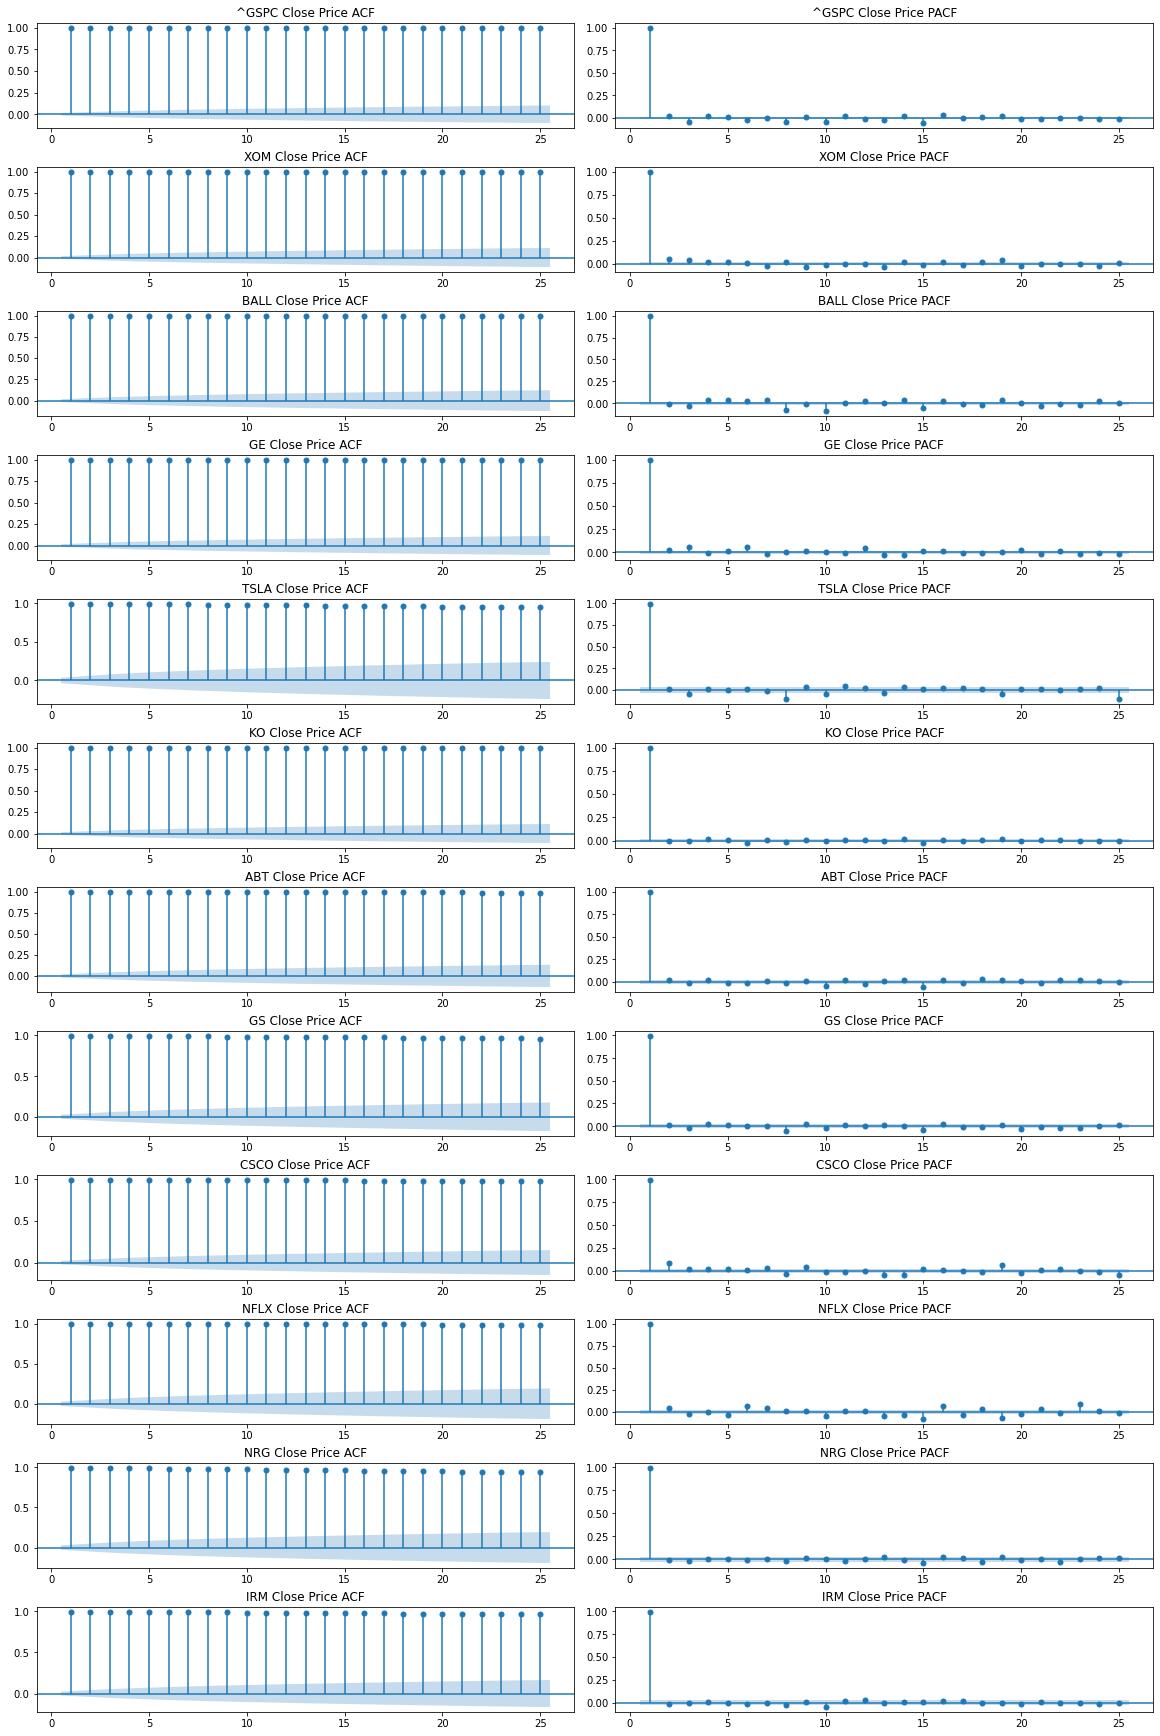

In [26]:
# Plotting ACF or PACF for closing prices

fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_prices_select = df_stock_prices[tickers[iticker]]['Close'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Close Price ACF')    
    fig = plot_pacf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Close Price PACF')    

plt.show()

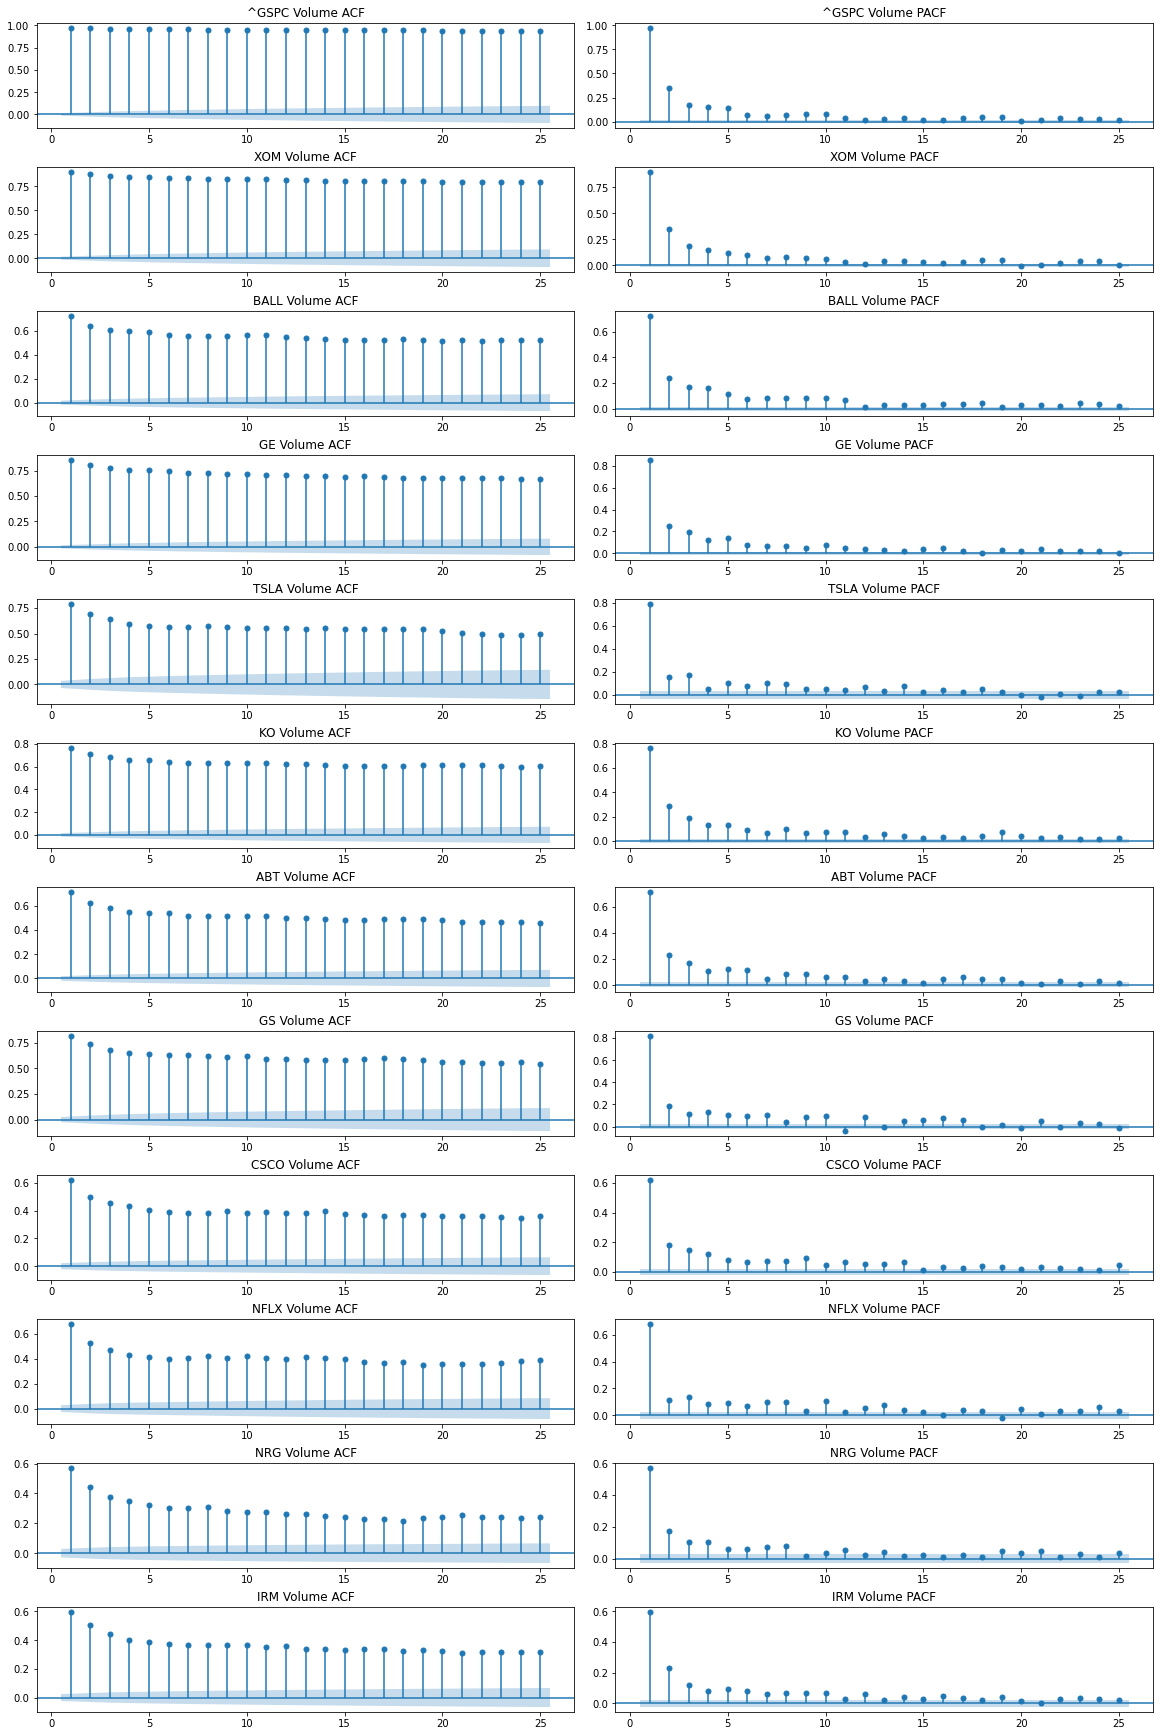

In [27]:
# Plotting ACF or PACF for trading volume
fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_prices_select = df_stock_prices[tickers[iticker]]['Volume'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Volume ACF')    
    fig = plot_pacf(df_stock_prices_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Volume PACF')    

plt.show()

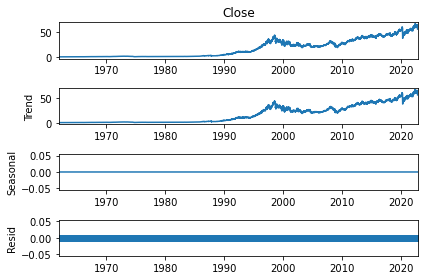

In [28]:
# Trend + seasonal + residual for stock market closing prices
iseason = seasonal_decompose(df_stock_prices['KO']['Close'].dropna(), model='additive', period = 1) 
iseason.plot()
plt.show()

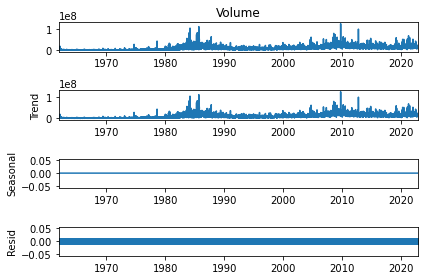

In [29]:
# Trend + seasonal + residual for stock market trading volume
iseason = seasonal_decompose(df_stock_prices['KO']['Volume'].dropna(), model='additive', period=1) 
iseason.plot()
plt.show()

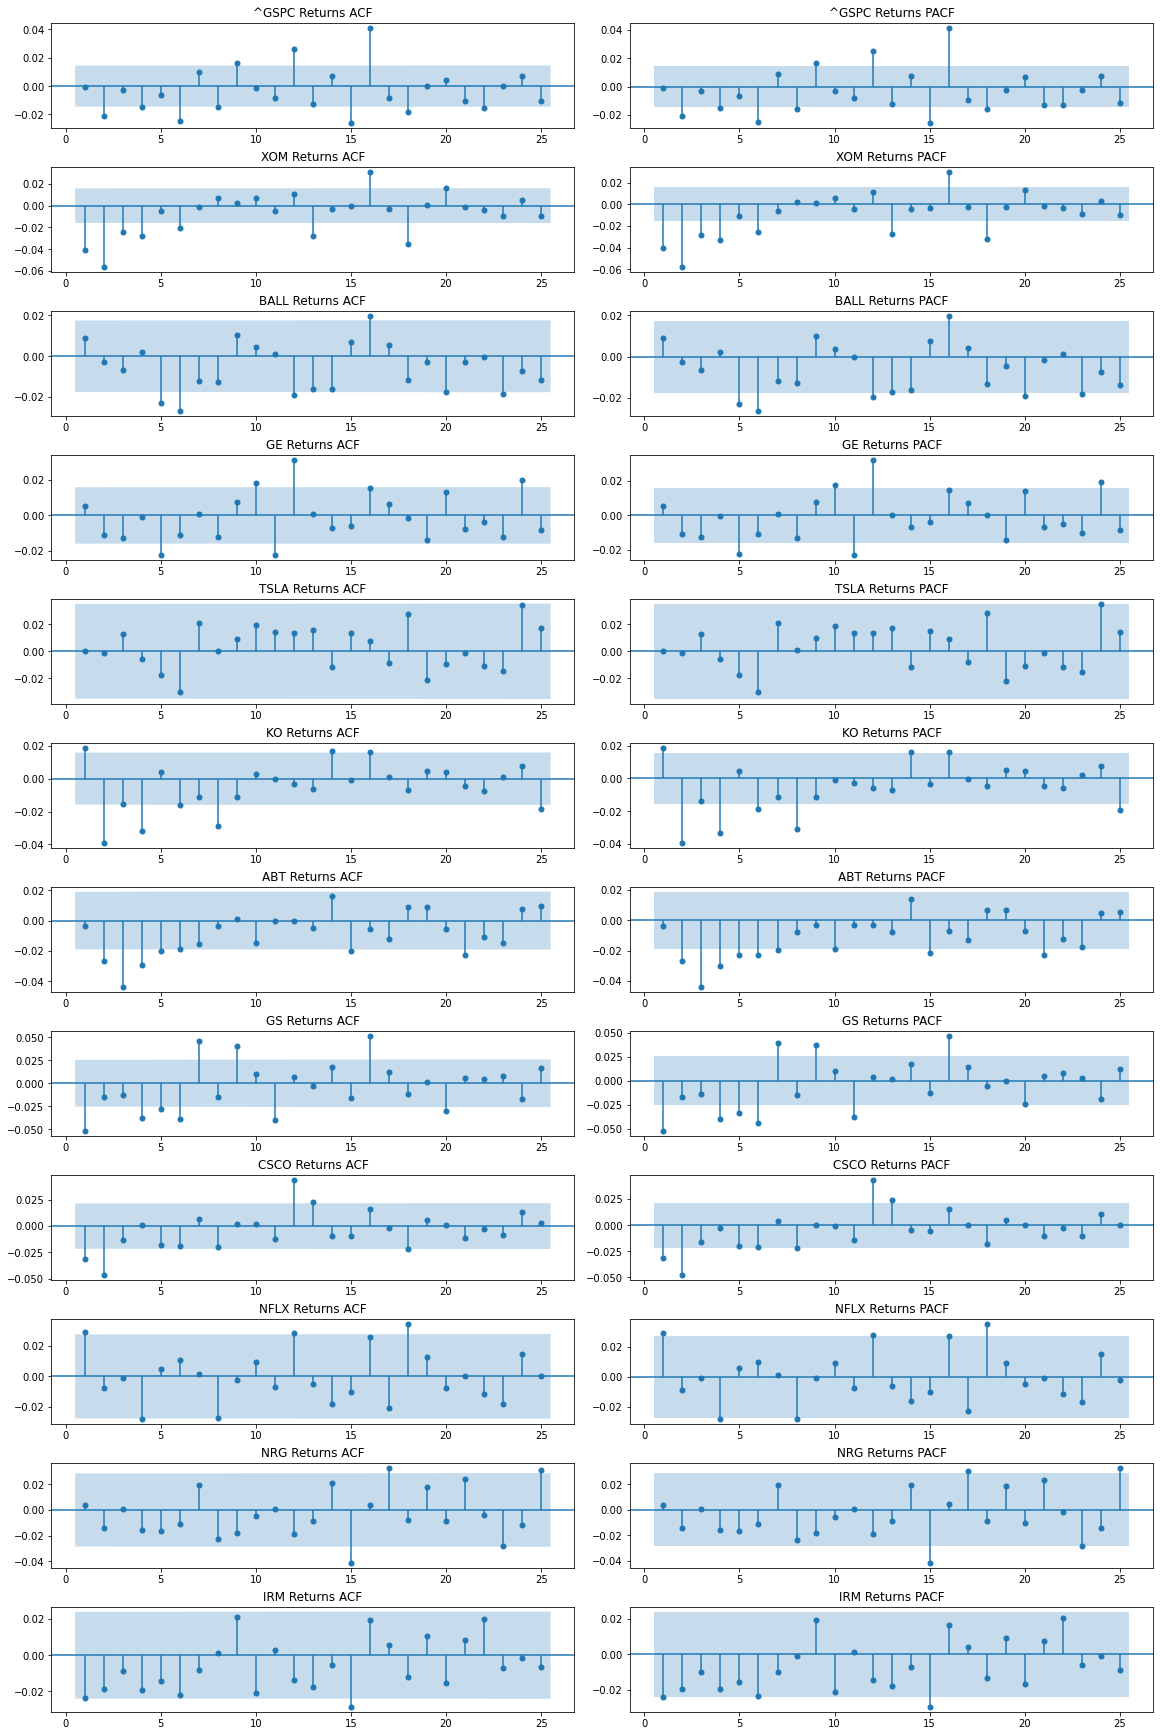

In [30]:
# Plotting ACF or PACF for stock returns
fig, axes = plt.subplots(12,2,figsize=(16,24), constrained_layout = True)

for iticker in range(len(tickers)):
    df_stock_returns_select = df_stock_returns[tickers[iticker]]['Close'].dropna() 
    # Create subplots
    fig = plot_acf(df_stock_returns_select, lags=25, zero=False, ax=axes[iticker,0], title=tickers[iticker] + ' Returns ACF')    
    fig = plot_pacf(df_stock_returns_select, lags=25, zero=False, ax=axes[iticker,1], title=tickers[iticker] + ' Returns PACF')    

plt.show()

#### Augmented Dickey Fuller (ADF) Stationarity Test

In [31]:
num_nonstationary = 0

for iticker in range(len(tickers)):
    iresult_adtest = adfuller(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('ADF Statistic: %f' % iresult_adtest[0])
    print('pvalue: %f' % iresult_adtest[1])
    print('Critical values:')
    for ikey, ivalue in iresult_adtest[4].items():
        print('\t%s: %.3f' % (ikey, ivalue))
    print('-'*100)
    
    if iresult_adtest[1] > 0.05:
        num_nonstationary += 1

if num_nonstationary == 0:
  print("All stock returns are stationary.")

^GSPC
ADF Statistic: -23.776393
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
XOM
ADF Statistic: -30.753055
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
BALL
ADF Statistic: -22.655108
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
GE
ADF Statistic: -19.342471
pvalue: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------------------
TSLA
ADF Statistic: -55.529904
pvalue: 0.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
----------------------------------------------------------------------------------------

#### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Stationarity Test

In [32]:
num_nonstationary = 0

for iticker in range(len(tickers)):
    iresult_kpsstest = kpss(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('KPSS Statistic: %f' % iresult_kpsstest[0])
    print('pvalue: %f' % iresult_kpsstest[1])
    print('Critical values:')
    for ikey, ivalue in iresult_kpsstest[3].items():
        print('\t%s: %.3f' % (ikey, ivalue))
    print('-'*100)
    
    if iresult_kpsstest[1] < 0.05:
        num_nonstationary += 1

if num_nonstationary == 0:
  print("All stock returns are stationary.")

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Pro

^GSPC
KPSS Statistic: 0.057571
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
XOM
KPSS Statistic: 0.083093
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
BALL
KPSS Statistic: 0.046649
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
GE
KPSS Statistic: 0.225728
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
----------------------------------------------------------------------------------------------------
TSLA
KPSS Statistic: 0.118676
pvalue: 0.100000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
-------------------------------------------

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


#### Missing Values and Deleting duplicate data

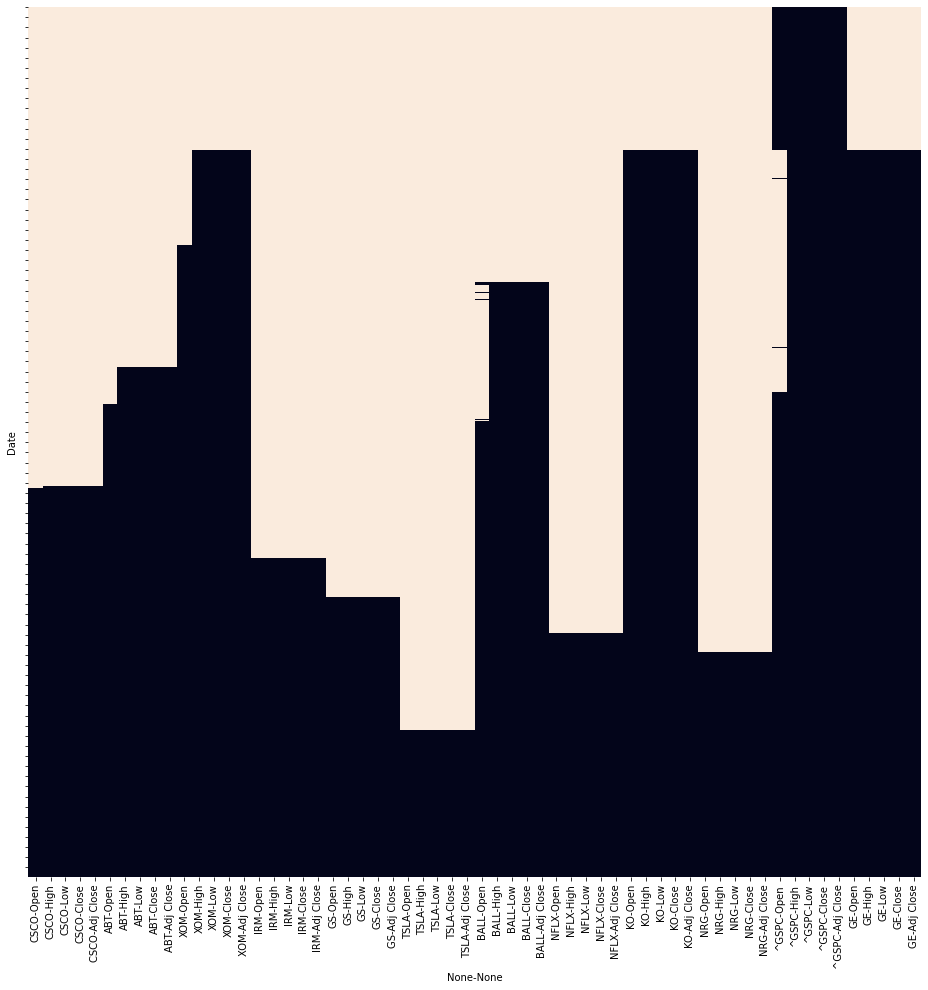

In [33]:
# Visualize the missing values
plt.figure(figsize=(16, 16))
heatmap_returns = sns.heatmap(df_stock_returns.isnull(), cbar=False)
heatmap_returns.set_yticklabels([])
plt.show()

In [36]:
# Creating a data frame consisting of stock returns
fields_prices    = ['Open', 'High', 'Low', 'Close', 'Adj Close']
fields_all       = df_stock_prices.columns.get_level_values(1).drop_duplicates().tolist()
fields_drop      = list(set(fields_all) - set(fields_prices))
print(fields_all)
print(fields_drop)
df_stock_prices = df_stock_prices.drop(fields_drop, level=1, axis=1)
display(df_stock_prices)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close SMA60', 'Close SMA250', 'Volume SMA60', 'Volume SMA250']
['Volume SMA250', 'Close SMA60', 'Close SMA250', 'Volume', 'Volume SMA60']


CSCO                                                     ABT  \
                 Open       High        Low      Close  Adj Close        Open   
Date                                                                            
1950-01-03        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-04        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-05        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-06        NaN        NaN        NaN        NaN        NaN         NaN   
1950-01-09        NaN        NaN        NaN        NaN        NaN         NaN   
...               ...        ...        ...        ...        ...         ...   
2022-09-26  40.660000  41.189999  40.369999  40.580002  40.580002  100.180000   
2022-09-27  41.139999  41.459999  40.230000  40.520000  40.520000  100.250000   
2022-09-28  40.849998  41.570000  40.590000  41.340000  41.340000   98.070000   
2022-09-29  41.049999  41.099998  40.150002  40.570000  40.570000   98.849998   
2022-09-30  40.660000  41.040001  39.959999  40.000000  40.000000   98.709999   

                                                         ...        ^GSPC  \
                  High        Low      Close  Adj Close  ...         Open   
Date                                                     ...                
1950-01-03         NaN        NaN        NaN        NaN  ...    16.660000   
1950-01-04         NaN        NaN        NaN        NaN  ...    16.850000   
1950-01-05         NaN        NaN        NaN        NaN  ...    16.930000   
1950-01-06         NaN        NaN        NaN        NaN  ...    16.980000   
1950-01-09         NaN        NaN        NaN        NaN  ...    17.080000   
...                ...        ...        ...        ...  ...          ...   
2022-09-26  100.650002  99.260002  99.839996  99.839996  ...  3682.719971   
2022-09-27  100.730003  97.910004  98.330002  98.330002  ...  3686.439941   
2022-09-28   99.269997  97.570000  98.720001  98.720001  ...  3651.939941   
2022-09-29   99.180000  97.550003  98.290001  98.290001  ...  3687.010010   
2022-09-30   99.500000  96.669998  96.760002  96.760002  ...  3633.479980   

                                                                       GE  \
                   High          Low        Close    Adj Close       Open   
Date                                                                        
1950-01-03    16.660000    16.660000    16.660000    16.660000        NaN   
1950-01-04    16.850000    16.850000    16.850000    16.850000        NaN   
1950-01-05    16.930000    16.930000    16.930000    16.930000        NaN   
1950-01-06    16.980000    16.980000    16.980000    16.980000        NaN   
1950-01-09    17.080000    17.080000    17.080000    17.080000        NaN   
...                 ...          ...          ...          ...        ...   
2022-09-26  3715.669922  3644.760010  3655.040039  3655.040039  64.529999   
2022-09-27  3717.530029  3623.290039  3647.290039  3647.290039  64.849998   
2022-09-28  3736.739990  3640.610107  3719.040039  3719.040039  64.989998   
2022-09-29  3687.010010  3610.399902  3640.469971  3640.469971  63.770000   
2022-09-30  3671.439941  3584.129883  3585.620117  3585.620117  62.639999   

                                                        
                 High        Low      Close  Adj Close  
Date                                                    
1950-01-03        NaN        NaN        NaN        NaN  
1950-01-04        NaN        NaN        NaN        NaN  
1950-01-05        NaN        NaN        NaN        NaN  
1950-01-06        NaN        NaN        NaN        NaN  
1950-01-09        NaN        NaN        NaN        NaN  
...               ...        ...        ...        ...  
2022-09-26  66.160004  64.209999  64.349998  64.349998  
2022-09-27  65.309998  63.509998  64.470001  64.470001  
2022-09-28  65.059998  64.190002  64.459999  64.459999  
2022-09-29  64.110001  61.919998  62.730

In [37]:
# Count duplicates in the stock prices data (we will remove derived indicators)
df_stock_prices_1lag = df_stock_prices.shift(1)
check_duplicates = (df_stock_prices_1lag == df_stock_prices)
check_duplicates = check_duplicates.drop(fields_drop, level=1, axis=1)
count_duplicates = check_duplicates.astype(int).sum()

print('check_duplicates')
print(check_duplicates)
print('-'*100)
print('count_duplicates')
print(count_duplicates)
print('-'*100)

check_duplicates
             CSCO                                   ABT                       \
             Open   High    Low  Close Adj Close   Open   High    Low  Close   
Date                                                                           
1950-01-03  False  False  False  False     False  False  False  False  False   
1950-01-04  False  False  False  False     False  False  False  False  False   
1950-01-05  False  False  False  False     False  False  False  False  False   
1950-01-06  False  False  False  False     False  False  False  False  False   
1950-01-09  False  False  False  False     False  False  False  False  False   
...           ...    ...    ...    ...       ...    ...    ...    ...    ...   
2022-09-26  False  False  False  False     False  False  False  False  False   
2022-09-27  False  False  False  False     False  False  False  False  False   
2022-09-28  False  False  False  False     False  False  False  False  False   
2022-09-29  False  Fals

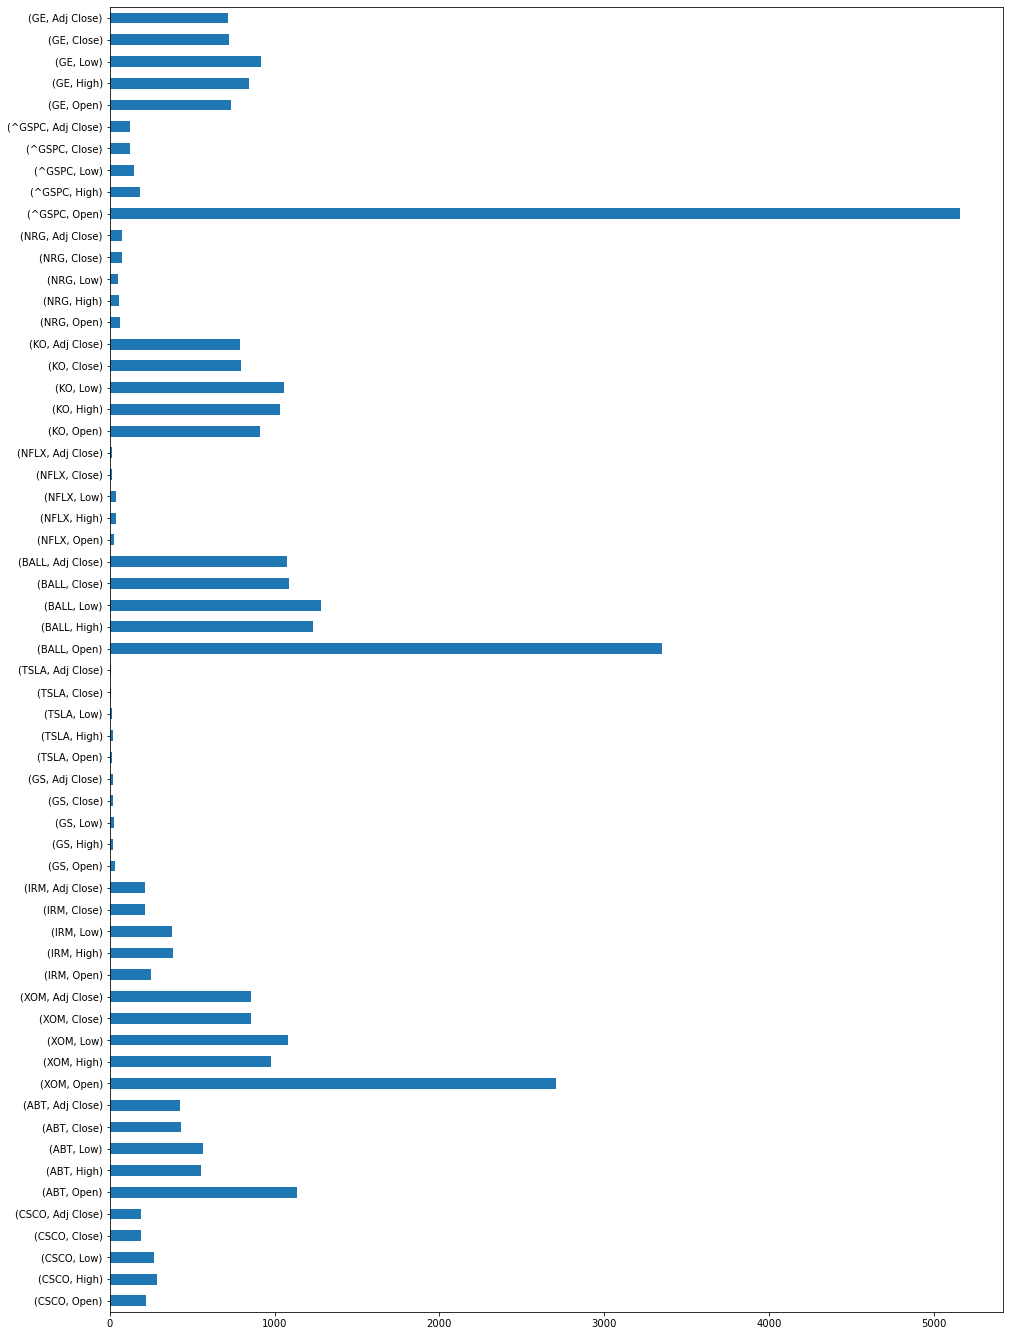

In [38]:
# Create a bar chart to visualize count_duplicates
plt.figure(figsize=(16, 24))
count_duplicates.plot.barh()
plt.show()

In [39]:
# Transform the duplicates indicator (should consist of NaNs, zeros, and ones for better visualization)
check_duplicates = check_duplicates.astype(int)
check_duplicates = check_duplicates.where(df_stock_prices.drop(fields_drop, level=1, axis=1).isna().values !=True, other=float('NaN'))

print('check_duplicates')
print(check_duplicates)

check_duplicates
           CSCO                            ABT                            ...  \
           Open High  Low Close Adj Close Open High  Low Close Adj Close  ...   
Date                                                                      ...   
1950-01-03  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-04  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-05  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-06  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
1950-01-09  NaN  NaN  NaN   NaN       NaN  NaN  NaN  NaN   NaN       NaN  ...   
...         ...  ...  ...   ...       ...  ...  ...  ...   ...       ...  ...   
2022-09-26  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-27  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-28  0.0  0.0  0.0   0.0       0.0  0.0  0.0  0.0   0.0       0.0  ...   
2022-09-29 

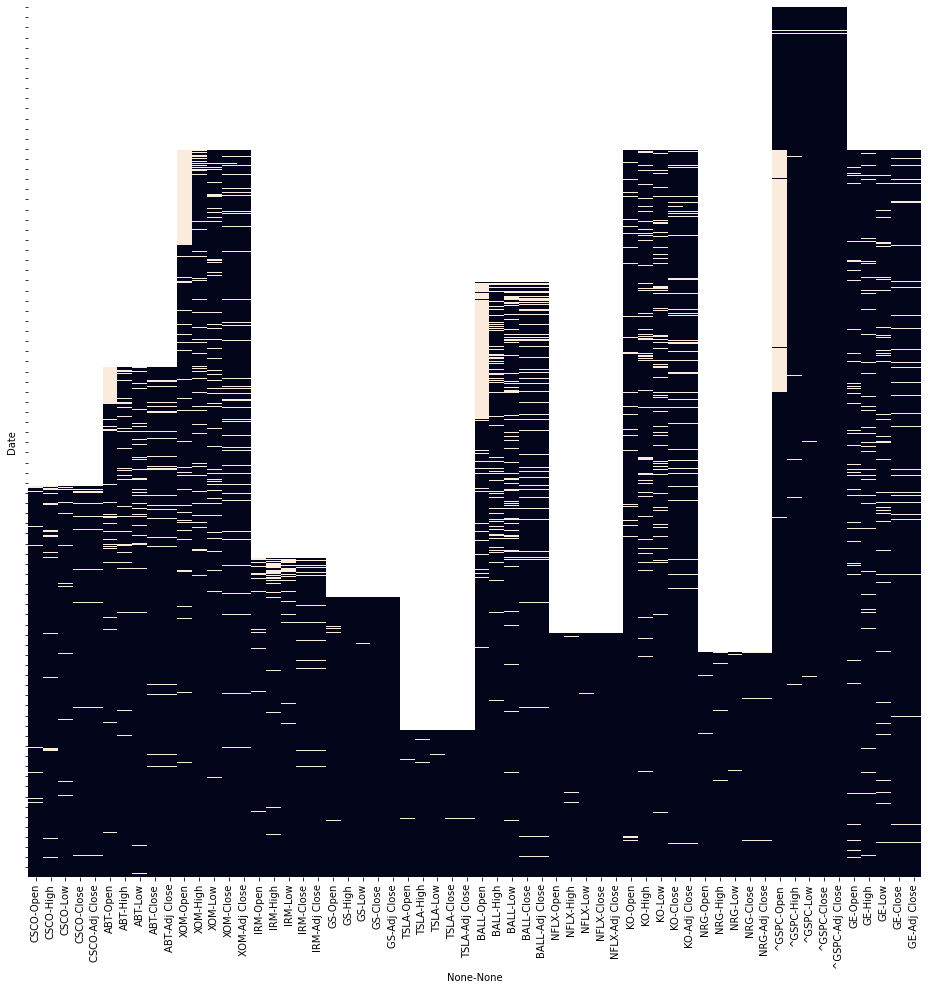

In [40]:
# Visualize the duplicates
plt.figure(figsize=(16, 16))
heatmap_duplicates = sns.heatmap(check_duplicates, cbar=False)
heatmap_duplicates.set_yticklabels([])
plt.show()

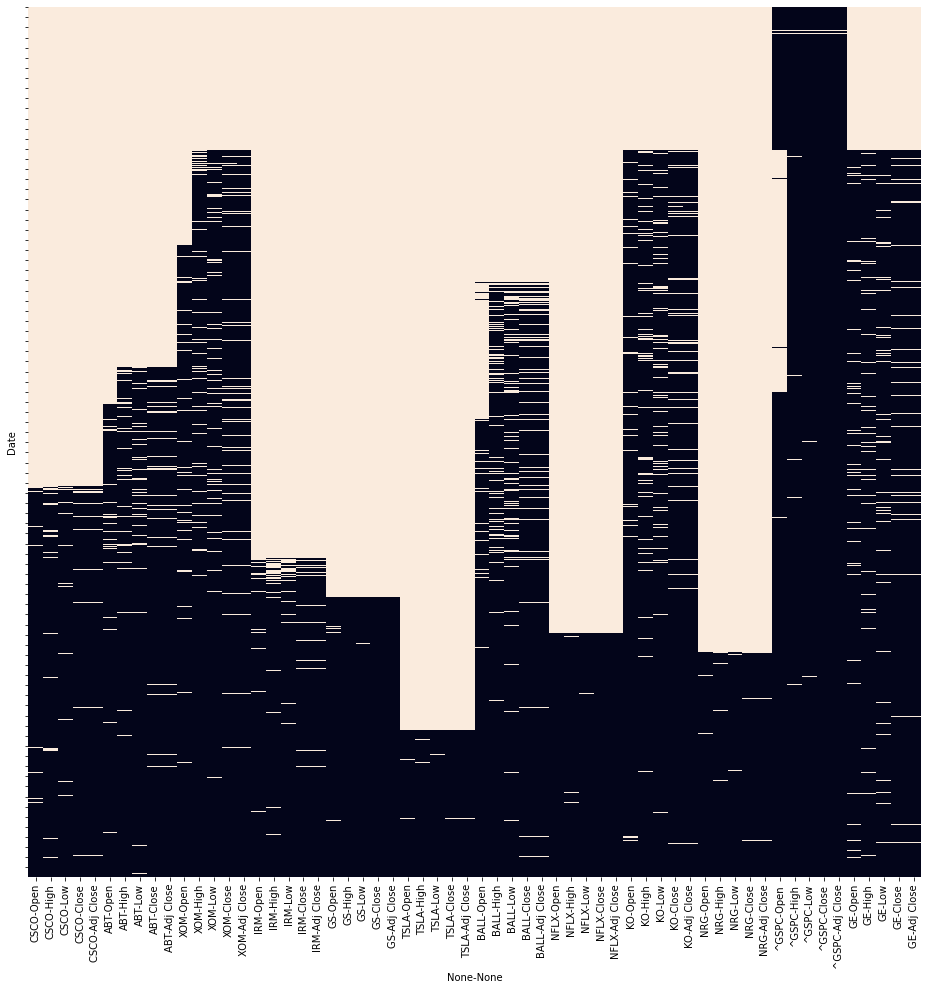

In [41]:
# Validation using stock returns instead of prices
df_stock_returns_doubleval = df_stock_returns.where((df_stock_returns != 'NaN') & ((df_stock_returns < -0.000001) | (df_stock_returns > 0.000001)))
plt.figure(figsize=(16, 16))
heatmap_returns_doubleval = sns.heatmap(df_stock_returns_doubleval.isnull(), cbar=False)
heatmap_returns_doubleval.set_yticklabels([])
plt.show()

In [42]:
# Replacement by combining the methods mask and fillna: First step 
df_stock_returns_final2 = df_stock_returns.mask(df_stock_returns==0).fillna(df_stock_returns.mean())
print(df_stock_returns_final2)

                CSCO                                               ABT  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       inf  0.000994  0.001062  0.001083  0.001124       inf   
1950-01-04       inf  0.000994  0.001062  0.001083  0.001124       inf   
1950-01-05       inf  0.000994  0.001062  0.001083  0.001124       inf   
1950-01-06       inf  0.000994  0.001062  0.001083  0.001124       inf   
1950-01-09       inf  0.000994  0.001062  0.001083  0.001124       inf   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.014303 -0.001455  0.006231 -0.001967 -0.001967 -0.002092   
2022-09-27  0.011805  0.006555 -0.003468 -0.001479 -0.001479  0.000699   
2022-09-28 -0.007049  0.002653  0.008949  0.020237  0.020237 -0.021746   
2022-09-29  0.004896 -0.011306 -0.010840 -0.018626 -0.018626  0.007953   
2022-09-30 -0.009501 -0.001460 -0.0047

In [43]:
# Replacement by combining the methods mask and fillna: Second step 
df_stock_returns_final2 = df_stock_returns_final2.where(df_stock_prices.drop(fields_drop, level=1, axis=1).isna().values==False, other=float('NaN'))
print(df_stock_returns_final2)

                CSCO                                               ABT  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.014303 -0.001455  0.006231 -0.001967 -0.001967 -0.002092   
2022-09-27  0.011805  0.006555 -0.003468 -0.001479 -0.001479  0.000699   
2022-09-28 -0.007049  0.002653  0.008949  0.020237  0.020237 -0.021746   
2022-09-29  0.004896 -0.011306 -0.010840 -0.018626 -0.018626  0.007953   
2022-09-30 -0.009501 -0.001460 -0.0047

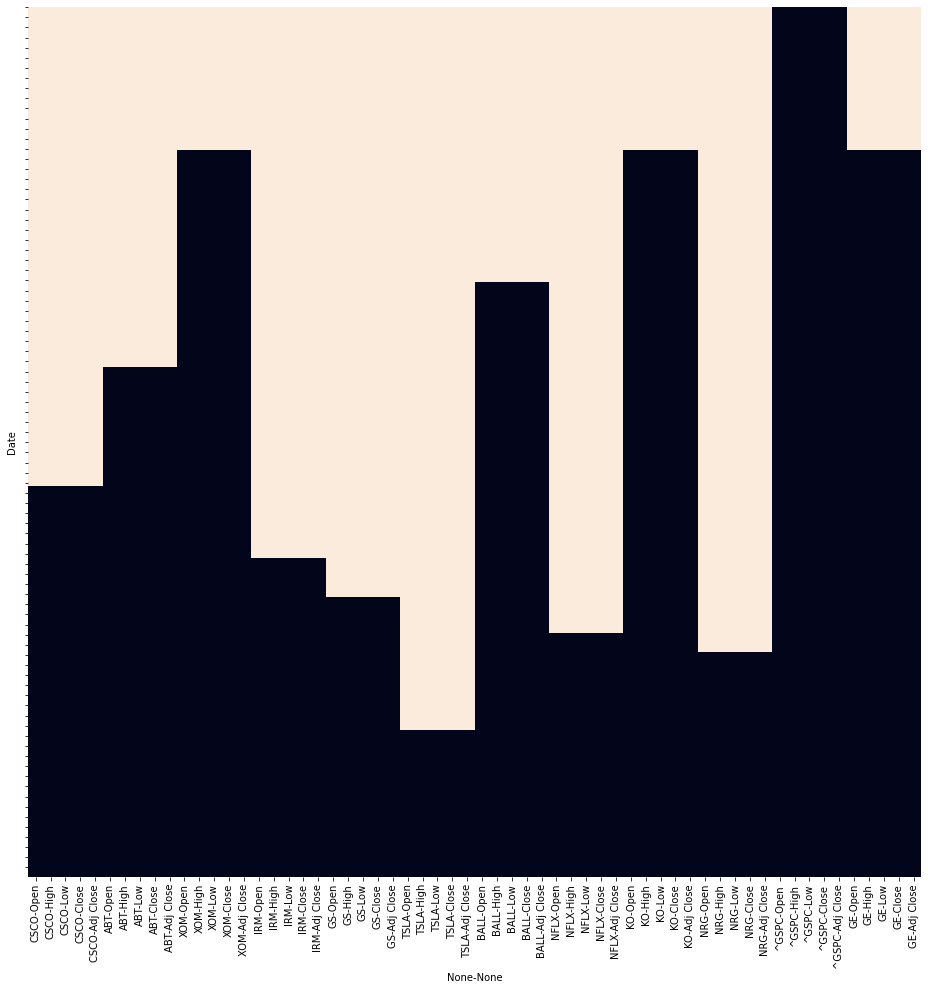

In [44]:
# Validation step (visalization)
df_stock_returns_doubleval2 = df_stock_returns_final2.where((df_stock_returns_final2 != float('NaN')) & ((df_stock_returns_final2 < -0.000001) | (df_stock_returns_final2 > 0.000001)))
plt.figure(figsize=(16, 16))
heatmap_returns_doubleval = sns.heatmap(df_stock_returns_doubleval2.isnull(), cbar=False)
heatmap_returns_doubleval.set_yticklabels([])
plt.show()

Plotting Outliers

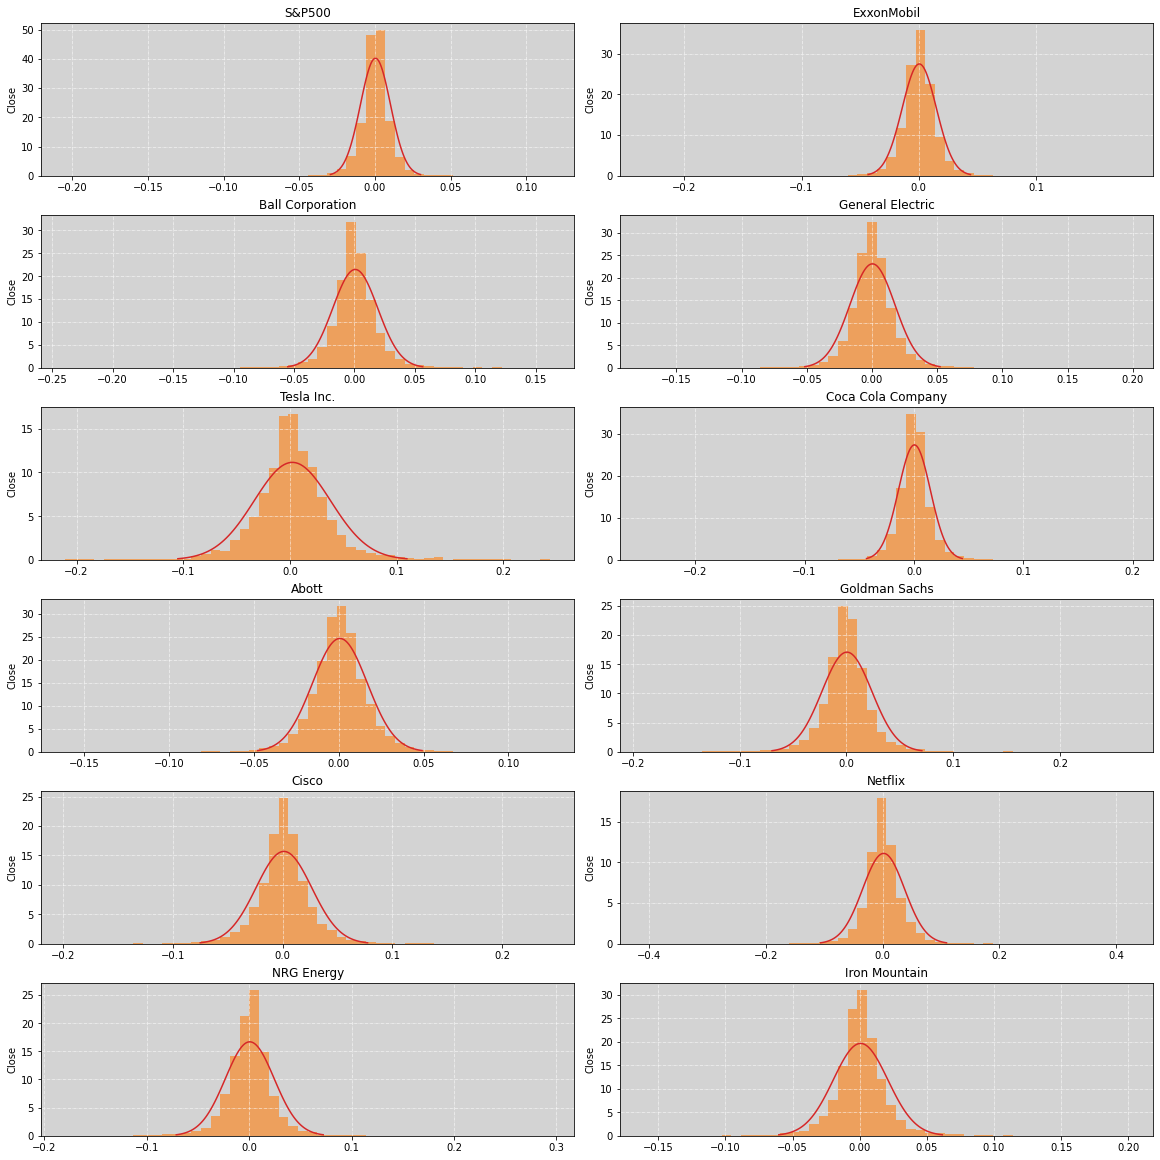

In [46]:
# Plotting returns histograms (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df_stock_returns_final2[tickers[iticker]]['Close'].mean()
    std_val   = df_stock_returns_final2[tickers[iticker]]['Close'].std()
    min_val   = df_stock_returns_final2[tickers[iticker]]['Close'].min()
    max_val   = df_stock_returns_final2[tickers[iticker]]['Close'].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = scipy.stats.norm.pdf(x_norm,mean_val,std_val)
    
    # Create subplots
    plt.subplot(6, 2, iticker+1)    
    df_stock_returns_final2[tickers[iticker]]['Close'].hist(bins=50, alpha=0.6, density=True, color='tab:orange')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

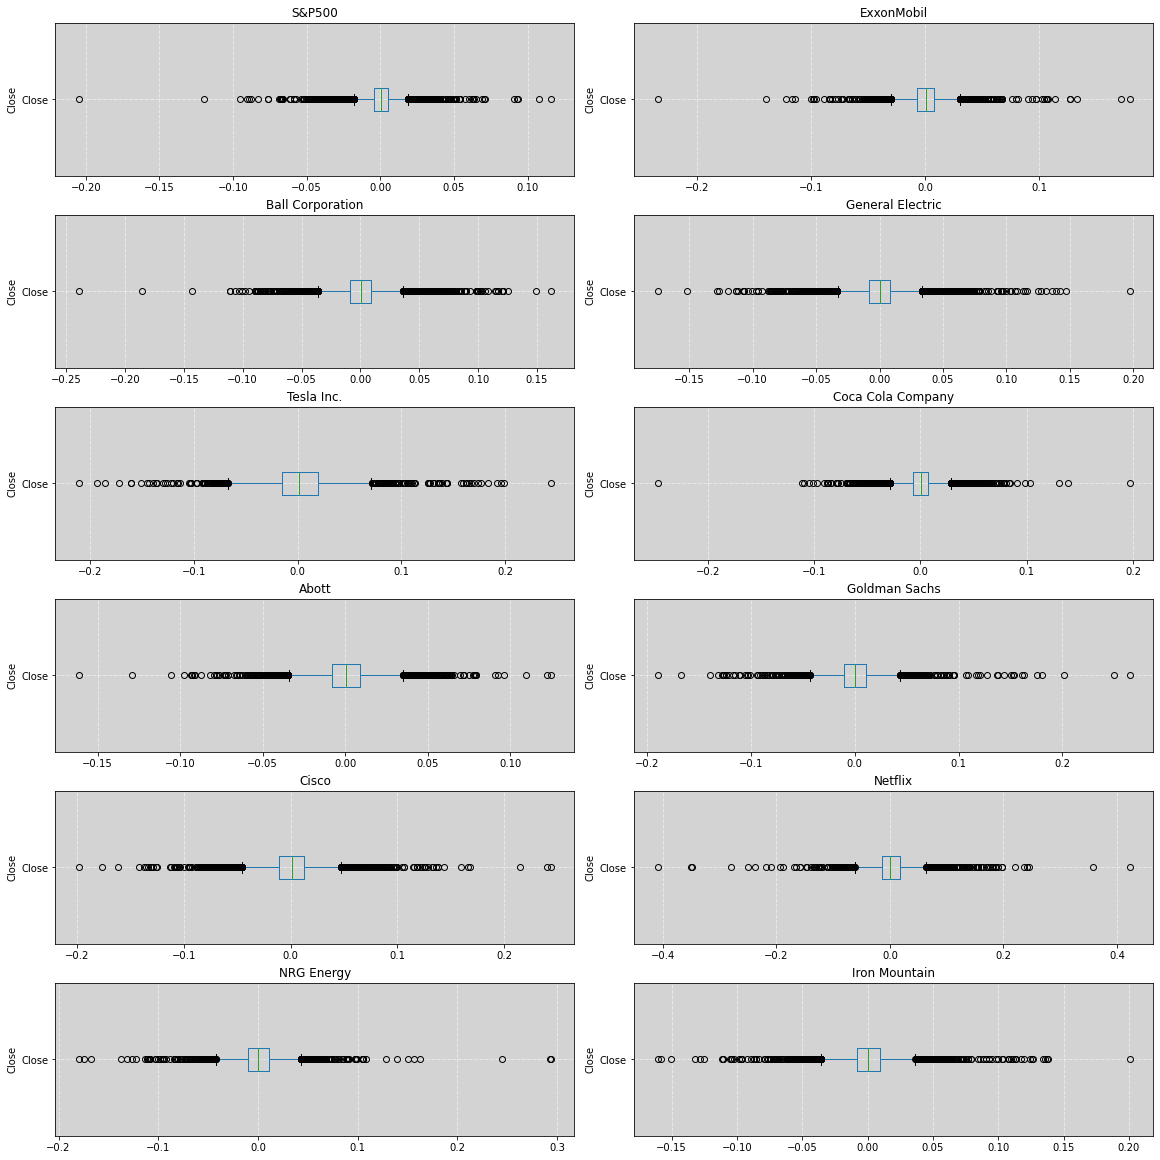

In [47]:
# Plotting returns boxplots (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    idf = df_stock_returns_final2[tickers[iticker]]
    idf.boxplot('Close',vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

In [48]:
# Compute skewness and kurtosis
print('Skewness:')
print(df_stock_returns_final2.skew())
print('-'*100)
print('Kurtosis:')
print(df_stock_returns_final2.kurt())
print('-'*100)

Skewness:
CSCO   Open              NaN
       High         0.165955
       Low          0.328659
       Close        0.258677
       Adj Close    0.255839
ABT    Open              NaN
       High         0.228738
       Low         -0.135554
       Close       -0.102846
       Adj Close   -0.102737
XOM    Open              NaN
       High         0.159398
       Low         -0.642272
       Close        0.008049
       Adj Close    0.013972
IRM    Open         0.390754
       High         1.357776
       Low         -0.280536
       Close        0.202671
       Adj Close    0.233248
GS     Open         0.674940
       High         1.025059
       Low          0.793934
       Close        0.719670
       Adj Close    0.716614
TSLA   Open         0.634954
       High         0.921293
       Low          0.349905
       Close        0.360012
       Adj Close    0.360012
BALL   Open              NaN
       High         0.564661
       Low         -0.263836
       Close        0.122172
    

In [49]:
# Create data frame with clipped stock returns
df_stock_returns_final_clip = df_stock_returns_final2.copy()
clip_returns = df_stock_returns_final2.clip(lower=df_stock_returns_final2.quantile(0.01), upper=df_stock_returns_final2.quantile(0.99), axis=1)
df_stock_returns_final_clip.iloc[:] = clip_returns 
display(df_stock_returns_final_clip)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CSCO                                               ABT  \
                Open      High       Low     Close Adj Close      Open   
Date                                                                     
1950-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
1950-01-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.014303 -0.001455  0.006231 -0.001967 -0.001967 -0.002092   
2022-09-27  0.011805  0.006555 -0.003468 -0.001479 -0.001479  0.000699   
2022-09-28 -0.007049  0.002653  0.008949  0.020237  0.020237 -0.021746   
2022-09-29  0.004896 -0.011306 -0.010840 -0.018626 -0.018626  0.007953   
2022-09-30 -0.009501 -0.001460 -0.004732 -0.014050 -0.014050 -0.001416   

                                                    ...     ^GSPC            \
                High       Low     Close Adj Close  ...      Open      High   
Date                                                ...                       
1950-01-03       NaN       NaN       NaN       NaN  ...       inf  0.000330   
1950-01-04       NaN       NaN       NaN       NaN  ...  0.011405  0.011405   
1950-01-05       NaN       NaN       NaN       NaN  ...  0.004748  0.004748   
1950-01-06       NaN       NaN       NaN       NaN  ...  0.002953  0.002953   
1950-01-09       NaN       NaN       NaN       NaN  ...  0.005889  0.005889   
...              ...       ...       ...       ...  ...       ...       ...   
2022-09-26 -0.002379  0.004554 -0.008343 -0.008343  ... -0.011918 -0.003077   
2022-09-27  0.000795 -0.013601 -0.015124 -0.015124  ...  0.001010  0.000501   
2022-09-28 -0.014494 -0.003473  0.003966  0.003966  ... -0.009359  0.005167   
2022-09-29 -0.000907 -0.000205 -0.004356 -0.004356  ...  0.009603 -0.013308   
2022-09-30  0.003226 -0.009021 -0.015566 -0.015566  ... -0.014519 -0.004223   

                                                GE                      \
                 Low     Close Adj Close      Open      High       Low   
Date                                                                     
1950-01-03  0.000338  0.000343  0.000343       NaN       NaN       NaN   
1950-01-04  0.011405  0.011405  0.011405       NaN       NaN       NaN   
1950-01-05  0.004748  0.004748  0.004748       NaN       NaN       NaN   
1950-01-06  0.002953  0.002953  0.002953       NaN       NaN       NaN   
1950-01-09  0.005889  0.005889  0.005889       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.000743 -0.010341 -0.010341 -0.000310  0.016595  0.010386   
2022-09-27 -0.005891 -0.002120 -0.002120  0.004959 -0.012848 -0.010902   
2022-09-28  0.004780  0.019672  0.019672  0.002159 -0.003828  0.010707   
2022-09-29 -0.008298 -0.021126 -0.021126 -0.018772 -0.014602 -0.035364   
2022-09-30 -0.007276 -0.015067 -0.015067 -0.017720 -0.012791 -0.000646   

                                
               Close Adj Close  
Date                            
1950-01-03       NaN       NaN  
1950-01-04       NaN       NaN  
1950-01-05       NaN       NaN  
1950-01-06       NaN       NaN  
1950-01-09       NaN       NaN  
...              ...       ...  
2022-09-26 -0.003098 -0.001861  
2022-09-27  0.001865  0.001865  
2022-09-28 -0.000155 -0.000155  
2022-09-29 -0.026838 -0.026838  
2022-09-30 -0.013072 -0.013072  

[18306 rows x 60 columns]

In [50]:
# Sanity check
print('Input returns minimum:')
print(df_stock_returns_final2.min())
print('-'*100)
print('Trimmed returns minimum:')
print(df_stock_returns_final_clip.min())
print('-'*100)
print('Input returns maximum:')
print(df_stock_returns_final2.max())
print('-'*100)
print('Trimmed returns maximum:')
print(df_stock_returns_final_clip.max())
print('-'*100)

Input returns minimum:
CSCO   Open        -0.193878
       High        -0.190954
       Low         -0.207208
       Close       -0.198276
       Adj Close   -0.198276
ABT    Open        -0.149020
       High        -0.124031
       Low         -0.192118
       Close       -0.161375
       Adj Close   -0.161375
XOM    Open        -0.177062
       High        -0.157935
       Low         -0.290230
       Close       -0.234286
       Adj Close   -0.234286
IRM    Open        -0.172434
       High        -0.147050
       Low         -0.182060
       Close       -0.160714
       Adj Close   -0.160715
GS     Open        -0.268705
       High        -0.164285
       Low         -0.260000
       Close       -0.189596
       Adj Close   -0.189596
TSLA   Open        -0.210924
       High        -0.185493
       Low         -0.185905
       Close       -0.210628
       Adj Close   -0.210628
BALL   Open        -1.000000
       High        -0.137931
       Low         -0.273333
       Close       -

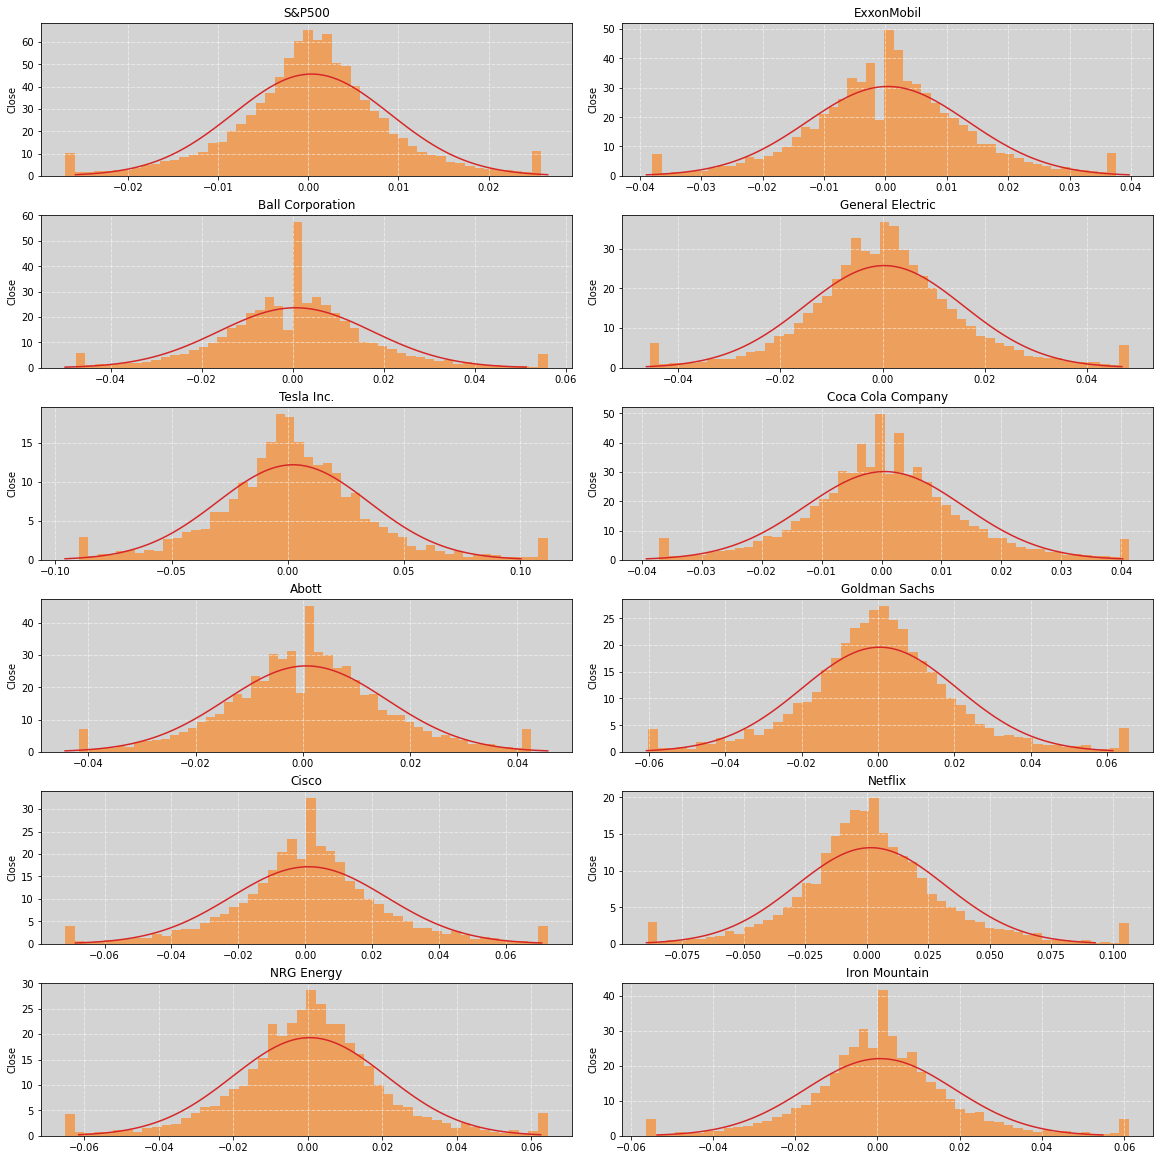

In [51]:
# Plotting returns histograms after clipping (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Prepare inputs for normal distribution plot overlay
    mean_val  = df_stock_returns_final_clip[tickers[iticker]]['Close'].mean()
    std_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].std()
    min_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].min()
    max_val   = df_stock_returns_final_clip[tickers[iticker]]['Close'].max()
    x_norm    = np.linspace(mean_val-3*std_val, mean_val+3*std_val, 100)  # alternative: np.linspace(min_val, max_val, 100)
    #x_norm    = np.linspace(min_val, max_val, 100)
    y_norm  = scipy.stats.norm.pdf(x_norm,mean_val,std_val) 
    
    # Create subplots
    plt.subplot(6, 2, iticker+1)    
    df_stock_returns_final_clip[tickers[iticker]]['Close'].hist(bins=50, alpha=0.6, density=True, color='tab:orange')
    plt.plot(x_norm, y_norm, color='tab:red', linewidth=1.5)
    
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

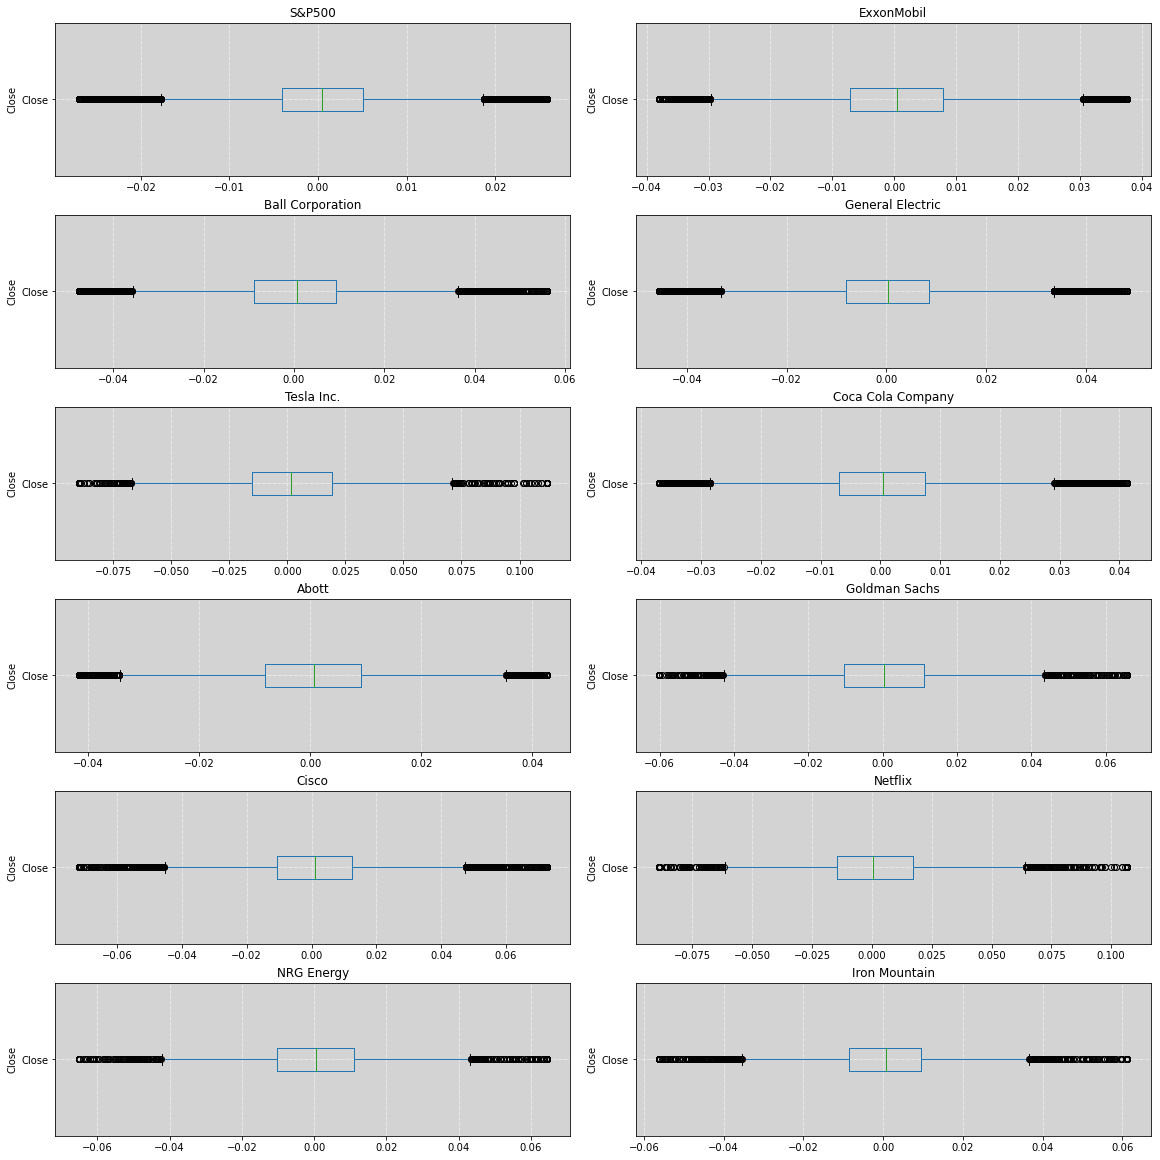

In [52]:
# Plotting returns boxplots after clipping (for returns based on closing prices)
plt.figure(figsize=(16, 16), constrained_layout = True)

for iticker in range(len(tickers)):
    # Create subplots
    plt.subplot(6, 2, iticker+1)
    idf = df_stock_returns_final_clip[tickers[iticker]]
    idf.boxplot('Close',vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Close')
    plt.title(names[iticker])
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

### a) Normality  
* Create Q–Q plots for each time series. Discuss the results.
* Run normality tests, e.g., Jarque–Bera, Shapiro–Wilk, Anderson–Darling, and D’Agostino K-squared tests. Consider possible input parameters in the applied methods, briefly describe the tests, and discuss your choices and findings. To run these tests, consider scipy.stats (or any other relevant package).

#### qq Plots

In [115]:
import scipy.stats as stats
import matplotlib.pyplot as plt

^GSPC


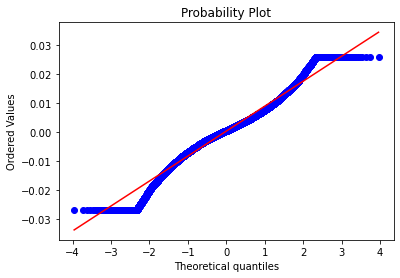

XOM


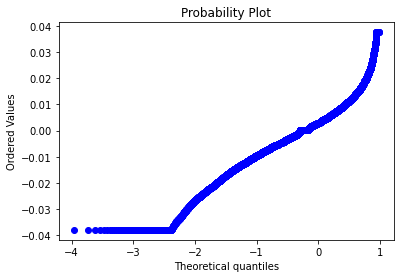

BALL


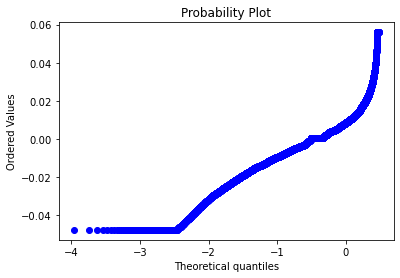

GE


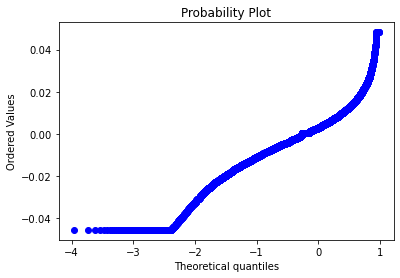

TSLA


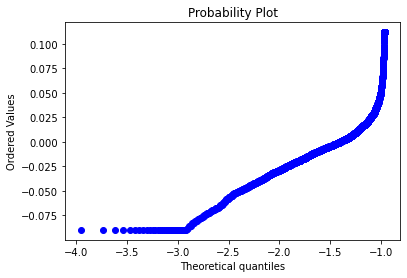

KO


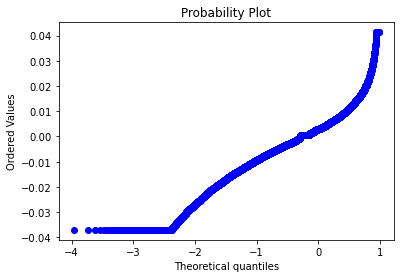

ABT


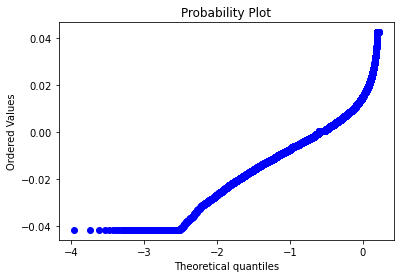

GS


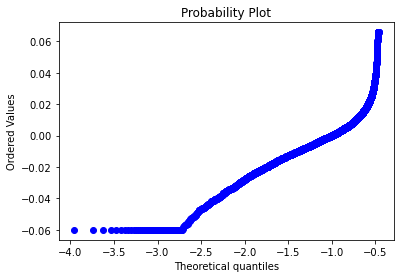

CSCO


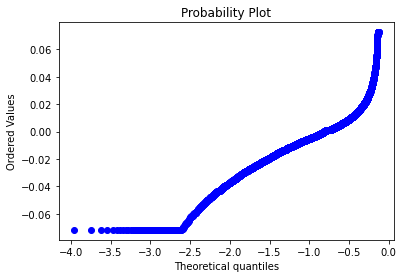

NFLX


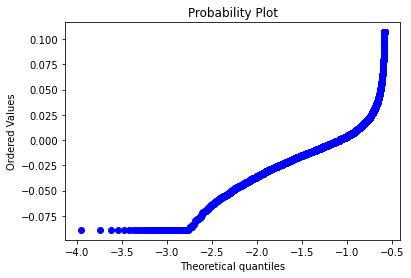

NRG


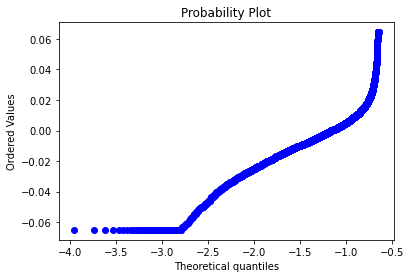

IRM


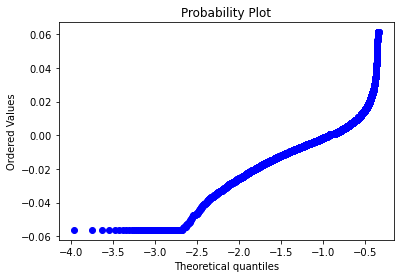

In [123]:
for iticker in range(len(tickers)):
    print(tickers[iticker])
    stats.probplot(df_stock_returns_final_clip[tickers[iticker]]['Close'], dist="norm", plot=py)
    py.show()

#### Normality Tests

In [111]:
#Jarque–Bera

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_jbtest = scipy.stats.jarque_bera(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('JB Statistic: %f' % iresult_jbtest[0])
    print('pvalue: %f' % iresult_jbtest[1])
    print('-'*100)
    
    if iresult_jbtest[1] > 0.05:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.")      

^GSPC
JB Statistic: 320665.126879
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
XOM
JB Statistic: 115202.826455
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
BALL
JB Statistic: 37530.097674
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
GE
JB Statistic: 46519.423789
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
TSLA
JB Statistic: 3750.180350
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
KO
JB Statistic: 102300.539018
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
ABT
JB Statistic: 10653.745725
pvalue: 0.000000
------------------------------------------------------

In [146]:
#Shapiro–Wilk
# 
#Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
#Ha(Rejected): Sample is not from the normal distributions.

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_swtest = scipy.stats.shapiro(df_stock_returns[tickers[iticker]]['Close'].dropna())
    print(tickers[iticker])
    print('Shapiro Wilk Statistic: %f' % iresult_swtest[0])
    print('pvalue: %f' % iresult_swtest[1])
    print('-'*100)
    
    if iresult_swtest[1] > 0.05:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
Shapiro Wilk Statistic: 0.896751
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
XOM
Shapiro Wilk Statistic: 0.926351
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
BALL
Shapiro Wilk Statistic: 0.925060
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
GE
Shapiro Wilk Statistic: 0.922182
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
TSLA
Shapiro Wilk Statistic: 0.930423
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
KO
Shapiro Wilk Statistic: 0.928127
pvalue: 0.000000
----------------------------------------------------------------------------------------------------
ABT
Shapiro Wilk Statistic: 0.959636
pvalue: 0.000000
--------------

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [178]:
#Anderson Darling Test

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_adtest = scipy.stats.anderson(df_stock_returns[tickers[iticker]]['Close'].dropna(), dist= 'norm')
    print(tickers[iticker])
    print('Anderson Darling Statistic: %f' % iresult_adtest[0])
    vector = np.vectorize(np.int_)
    print('pvalue:')
    print(*iresult_adtest[1], sep = ", ")
    print('significance level:')
    print(*iresult_adtest[2], sep = ", ")
    print('-'*100)
    
    if iresult_adtest[0] > 0.641:
        num_nonnormal += 1
        
if num_nonnormal == 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
Anderson Darling Statistic: 288.594211
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
XOM
Anderson Darling Statistic: 136.679211
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
BALL
Anderson Darling Statistic: 167.273792
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
GE
Anderson Darling Statistic: 196.281602
pvalue:
0.576, 0.656, 0.787, 0.918, 1.092
significance level:
15.0, 10.0, 5.0, 2.5, 1.0
----------------------------------------------------------------------------------------------------
TSLA
Anderson Darling Statistic: 42.385898
pvalue:
0.575, 0.655, 0.786

In [184]:
#D’Agostino K-squared tests

num_nonnormal = 0

for iticker in range(len(tickers)):
    iresult_daktest = scipy.stats.normaltest(df_stock_returns[tickers[iticker]]['Close'].dropna(), nan_policy='omit')
    print(tickers[iticker])
    print('D’Agostino K-squared: %f' % iresult_daktest[0])
    print('p value: %f' % iresult_daktest[1])
        
    if iresult_daktest[1] < 1e-3:
        num_nonnormal += 1
        
if num_nonnormal > 0:
  print("None of the stock returns follow normal distribution.") 

^GSPC
D’Agostino K-squared: 5581.776803
p value: 0.000000
XOM
D’Agostino K-squared: 3116.372578
p value: 0.000000
BALL
D’Agostino K-squared: 2016.493777
p value: 0.000000
GE
D’Agostino K-squared: 2499.169689
p value: 0.000000
TSLA
D’Agostino K-squared: 427.277811
p value: 0.000000
KO
D’Agostino K-squared: 3035.088097
p value: 0.000000
ABT
D’Agostino K-squared: 1176.488469
p value: 0.000000
GS
D’Agostino K-squared: 1610.489111
p value: 0.000000
CSCO
D’Agostino K-squared: 1280.360547
p value: 0.000000
NFLX
D’Agostino K-squared: 1229.093999
p value: 0.000000
NRG
D’Agostino K-squared: 1489.351687
p value: 0.000000
IRM
D’Agostino K-squared: 1173.472932
p value: 0.000000
None of the stock returns follow normal distribution.


### b) Multivariate Analysis

* Compute and visualize (e.g., using a heatmap) the correlation matrix. Discuss your findings, i.e., try to provide a rationale why some pairs of stocks might have higher correlation that others. To answer this question, select up to five representative figures from the correlation matrix.
* Calculate the [Mahalanobis distance (MD)](https://en.wikipedia.org/wiki/Mahalanobis_distance) for the selected eleven stocks (i.e., exclude the S&P 500 index). Download daily time series of the CBOE volatility index (VIX), and plot the MD and VIX in the same graph. Discuss your findings.

# 2 FRED–MD: A Database for Macroeconomic Research

Consider the Federal Reserve Bank of St. Louis’ monthly database of macroeconomic factors created by [Michael W. McCracken et al](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The data and the associated research paper are provided on the shared drive. The list of all variables and the respective recommended data transformations are listed in the appendix of the paper (pp. 586–588).

In this exercise, you will conduct an exploratory data analysis for a subset of the FRED–MD database. You can use and possibly amend your EDA code generated for the US stock market analysis in the previous exercise. You are free to choose which types of data presentations and statistical testing are relevant for this particular data set. Last but not least, you are most welcome to introduce your own ideas and add other tests and procedures (in which case you might be awarded bonus points). For each of the questions listed below, please provide plots or tables where necessary, justify your choices, and discuss your results.

### a) Data selection: 
From each of the eight data categories presented in the paper select one representative variable.

### (b) High-level overview: 
Present basic information about your data set in tabular or visual form.

### (c) Data transformations: 
Apply data transformations and run some stationarity tests.

### (d) Missing observations: 
Impute missing values using your preferred approach. If there are no missing values in your data set, randomly remove some observations just for this part of the exercise. Justify your choice(s).

### (e) Outliers: 
Implement at least one approach for detection of outliers. Justify your choices (even if you do not remove any outliers).

### (f) Normality: 
Explore (i.e., visually and formally by using statistical tools) if the data are normally distributed.

### (g) Multivariate analysis: 
Compute and visualize (e.g., using a heatmap) the correlation matrix and discuss the results (e.g., pick some examples and provide a rationale why those correlation coefficients make or do not make sense).